<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-del-projecto-equipo-41/blob/main/Reto_Entrega_1_Equipo41.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portada
---

<br>
<p align=center>Instituto Tecnológico y de Estudios Superiores de Monterrey</p>
<p align=center>Escuela de Ingeniería y Ciencias</p>
<p align=center>
<br>
<img src="https://github.com/PosgradoMNA/actividades-del-projecto-equipo-41/blob/main/tec.png?raw=true" alt="Logo" width="250"/>
</p>
<br>
<p align=center>Maestría en Inteligencia Artificial Aplicada (MNA)</p>
<p align=center>TC4029. Ciencia y Analítica de Datos</p>
<p align=center> Profesor Titular: María de la Paz Rico </p>
<p align=center> <b>Reto Final - Parte I (EDA)</b> </p>
<br>
<p align=center>Presentan:</p>
<p align=center>A01150742 | Ovalle Alvarado José</p>
<p align=center>A01793023 | Arroyo Chavelas Jorge Luis</p>
<p align=center>16 de Noviembre de 2022</p>
<br>
<br>
<p align=center><small><italic>“Por medio de la presente hacemos constar que el reporte que estamos enviando es de nuestra completa autoría y que no estamos haciendo plagio de ideas o escritos del trabajo de otras personas”</italic></small></p>

---

[GitHub Link](https://github.com/PosgradoMNA/actividades-del-projecto-equipo-41/blob/main/Reto_Entrega_1_Equipo41.ipynb)


# Introducción

En este documento, presentamos un análisis de datos de la calidad de aguas subterraneas con muestras del 2020. En esta primera parte nos enfocaremos en un análisis exploratorio de los datos, pero este trabajo servirá también como base para un modelo de predicción del semaforo de calidad de la misma, por lo que la metodología irá encaminada no sólo al análisis sino a un proyecto de ciencia de datos y aprendizaje automático completo; desde su análisis exploratorio hasta la presentación de un modelo de clasificación para este semaforo.

Preapremos primero nuestro ambiente de análisis:

In [ ]:
# Algunas instalaciones previas para Colab:
!pip install -q qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

     |████████████████████████████████| 16.7 MB 7.2 MB/s 
     |████████████████████████████████| 1.0 MB 44.2 MB/s 
     |████████████████████████████████| 1.7 MB 22.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 66.8 MB/s 
     |████████████████████████████████| 6.3 MB 45.9 MB/s 


In [ ]:
############################################################################################
# Librerias y funciones:
############################################################################################

# Para obtener los datos
import requests
import zipfile
import io
import base64

# Para manipualr datos
import pandas as pd
import numpy as np

# Para visualizaciones:
from tabulate import tabulate
from matplotlib import pyplot as plt
import seaborn as sns

# Para particiones y validaciones
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Para transformaciones:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

# Para pipelines:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Para datos geográficos
from shapely.geometry import Point
import geopandas as gpd
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from scipy.spatial import ConvexHull
from PIL import Image

# Otras utilidades
import functools
import warnings

sns.set_theme(style='white', palette=None)
%matplotlib inline

Obtengamos los datos:

In [ ]:
############################################################################################
# Llamar los datos:
############################################################################################

# Definir la url de donde obtener los datos:
datos_url = 'http://201.116.60.46/Datos_de_calidad_del_agua_de_5000_sitios_de_monitoreo.zip'

# Obtener la respuesta:
datos_response = requests.get(datos_url, stream=True)

# Tomar respuesta como zip en cache:
datos_zip = zipfile.ZipFile(io.BytesIO(datos_response.content))

# Extraer todos los archivos del zip en nuestro espacio local:
datos_zip.extractall("./")

# Definir el lugar donde guardamos los archivos:
datos_dir = './Datos_de_calidad_del_agua_2020'

# Definir archivos a utilizar
datos_file = '/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv'

# Impotar los datos:
df = pd.read_csv(datos_dir + datos_file, encoding = "cp1252")

# Confirmemos que tenemos el dataset:
print(f'\n Dataframe con {df.shape} dimensiones')


 Dataframe con (1068, 57) dimensiones


Ahora, antes de comenzar a revisar los datos, recurramos a un poco de magia buscando en el servidor de origen para llamar también al diccionario correspondiente a estos datos, ésto nos ayudará a dar mejores conclusiones en nuetro análisis exploratirio – Después de todo, ¿No es acaso descubrir lo creado hacer ciencia? Y esto es ciencia de datos, así que usemos lo disponible.

In [ ]:
############################################################################################
# Llamar al diccionario de datos:
############################################################################################

# Definir la url de donde obtener los datos:
diccionario_url = 'http://201.116.60.46/Diccionario_Datos_de_calidad_del_agua_de_5000_sitios_de_monitoreo.zip'

# Obtener la respuesta:
diccionario_response = requests.get(diccionario_url, stream=True)

# Tomar respuesta como zip en cache:
diccionario_zip = zipfile.ZipFile(io.BytesIO(diccionario_response.content))

# Extraer todos los archivos del zip en nuestro espacio local:
diccionario_zip.extractall("./")

# Definir el lugar donde guardamos los archivos:
diccionario_dir = './Diccionario_Datos_de_calidad_del_agua_de_5000_sitios_de_monitoreo'

# Definir archivos a utilizar
diccionario_file = '/Diccionario_datos_Subterraneal.csv'

# Impotar los datos:
diccionario = pd.read_csv(diccionario_dir + diccionario_file, encoding = "UTF-8")

In [ ]:
# Demos una vista rápida al diccionario:
display(diccionario.head())
print(diccionario.shape)

,CAMPO,DESCRIPCION,TIPO,VALOR_POSIBLE
0,CLAVE,Clave del sitio de monitoreo,Texto,A - Z
1,SITIO,Nombre del sitio de muestreo,Texto,A - Z
2,ID_ORGANISMO_DE_CUENCA,Identificador de Organismo de Cuenca,Numerico,Entero
3,NOMBRE_ORGANISMO_DE_CUENCA,Nombre del Organismo de Cuenca de agua donde s...,Texto,A - Z
4,ID_ESTADO,Identificador de Estado,Numerico,Entero


(62, 4)


¡Excelente!, este diccionario y un poco de técnicas exploratorias nos permitirá explicar a mayor detalle los datos que usaremos en esta entrega.

# EDA - Primeros pasos

Como ya hemos definido, el color de semaforo en las aguas será nuestra variable objetivo, lo que convierte a las demás en nuestros *features*. Esto sugiere hacer una separación en una matriz X y un vector y basado en nuestros datos. Sería además conveniente, que realicemos una separación de estos valores en conjuntos de entrenamiento y de prueba, tanto para crear un modelo más robusto en terminos de generalización, como para crear *pipelines* que nos eviten caer en problemas de *data leak* si este modelo llega a estar en producción.

In [ ]:
############################################################################################
# Datos de entrenamiento y prueba:
############################################################################################

# Conjunto con features
X = df.drop('SEMAFORO', axis=1)

# Variable objetivo
y = df[['SEMAFORO']]

# Partir los datos en conjuntos de entrenamiento y prueba:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"""
Tamaño de variables de entrenamiento: {X_train.shape} || tamaño de objetivo entrenamiento: {y_train.shape}
Tamaño de variables de prueba: {X_test.shape} || tamaño de objetivo prueba: {y_test.shape}
""")


Tamaño de variables de entrenamiento: (854, 56) || tamaño de objetivo entrenamiento: (854, 1)
Tamaño de variables de prueba: (214, 56) || tamaño de objetivo prueba: (214, 1)



Comencemos por ver los datos:

In [ ]:
# Vista inicial de los datos:
X_train.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
910,OCPBC4365,"PARCELA NO. 22, EJIDO LAGUNITAS",PENINSULA DE BAJA CALIFORNIA,SONORA,SAN LUIS RIO COLORADO,VALLE DE SAN LUIS RIO COLORADO,POZO,-114.904922,32.321953,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
944,OCPNO4596,EL ROBLE,PACIFICO NORTE,SINALOA,ELOTA,RIO ELOTA,POZO,-106.817410,23.921070,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
567,DLZAC2632,TRANCOSO,CUENCAS CENTRALES DEL NORTE,ZACATECAS,TRANCOSO,CHUPADEROS,POZO,-102.311340,22.770010,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
106,DLCHI401,LAGUNA DE PALOMAS 1,RIO BRAVO,CHIHUAHUA,JIMENEZ,ESCALON,POZO,-104.345890,26.751790,2020,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI
587,DLZAC2659,ESTANCIA LA COLORADA,CUENCAS CENTRALES DEL NORTE,ZACATECAS,VILLA DE COS,GUADALUPE DE LAS CORRIENTES,POZO,-102.394690,23.785910,2020,...,SI,SI,NO,NO,SI,SI,SI,SI,SI,SI


Veamos también los valores objetivo

In [ ]:
# Vista inicial de los datos objetivo:
pd.DataFrame(y_train['SEMAFORO'].value_counts())

,SEMAFORO
Verde,337
Rojo,319
Amarillo,198


Del cuadro previo podemos observar que la mayoría de las observaciones tienen semáforo "ROJO" / "AMARILLO". Esto sugiere que la calidad del agua en México es deficiente en la mayoría de los puntos geográficos descritos en el dataset.

Utilicemos el método info también para ver los tipos de datos y si estos contienen o no valores estrictamente nulos:

In [ ]:
# Tipo de dato y valroes en las variables:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 854 entries, 910 to 860
Data columns (total 56 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLAVE                 854 non-null    object 
 1   SITIO                 854 non-null    object 
 2   ORGANISMO_DE_CUENCA   854 non-null    object 
 3   ESTADO                854 non-null    object 
 4   MUNICIPIO             854 non-null    object 
 5   ACUIFERO              854 non-null    object 
 6   SUBTIPO               854 non-null    object 
 7   LONGITUD              854 non-null    float64
 8   LATITUD               854 non-null    float64
 9   PERIODO               854 non-null    int64  
 10  ALC_mg/L              850 non-null    float64
 11  CALIDAD_ALC           850 non-null    object 
 12  CONDUCT_mS/cm         849 non-null    float64
 13  CALIDAD_CONDUC        849 non-null    object 
 14  SDT_mg/L              0 non-null      float64
 15  SDT_M_mg/L           

Acorde a esto, tenemos 5 variables númericas, una de enteros y 50 como texto. Además encontramos que varias de estas contienen nulos, ya que no se cumplen los 854 valores para muchos de estas. Sin embargo, para estar seguros, hagamos una validación cruzada contra nuestro diccionario. Primero veamos nuestro diccionario una vez más

In [ ]:
# Valores acorde al diccionario:
diccionario.head(10)

,CAMPO,DESCRIPCION,TIPO,VALOR_POSIBLE
0,CLAVE,Clave del sitio de monitoreo,Texto,A - Z
1,SITIO,Nombre del sitio de muestreo,Texto,A - Z
2,ID_ORGANISMO_DE_CUENCA,Identificador de Organismo de Cuenca,Numerico,Entero
3,NOMBRE_ORGANISMO_DE_CUENCA,Nombre del Organismo de Cuenca de agua donde s...,Texto,A - Z
4,ID_ESTADO,Identificador de Estado,Numerico,Entero
5,NOMBRE_ESTADO,Estado donde se encuentra el sitio de muestreo,Texto,A - Z
6,ID_MUNICIPIO,Identificador de Municipio,Numerico,Entero
7,NOMBRE_MUNICIPIO,Municipio donde se encuentra el sitio de muestreo,Texto,A - Z
8,ID_ACUIFERO,Identificador de Acu¡fero,Numerico,Entero
9,ACUIFERO,Acu­fero donde se encuentra el sitio de muestreo,Texto,A - Z


Ahora utilicemos el método describe para ver las variables que nuestro dataset clásifico como numéricas:

In [ ]:
# Variables numéricas:
df.describe()

,LONGITUD,LATITUD,PERIODO,ALC_mg/L,CONDUCT_mS/cm,SDT_mg/L
count,1068.000000,1068.000000,1068.0,1064.000000,1062.000000,0.0
mean,-101.891007,23.163618,2020.0,235.633759,1138.953013,NaN
std,6.703263,3.887670,0.0,116.874291,1245.563674,NaN
min,-116.664250,14.561150,2020.0,26.640000,50.400000,NaN
25%,-105.388865,20.212055,2020.0,164.000000,501.750000,NaN
50%,-102.174180,22.617190,2020.0,215.527500,815.000000,NaN
75%,-98.974716,25.510285,2020.0,292.710000,1322.750000,NaN
max,-86.864120,32.677713,2020.0,1650.000000,18577.000000,NaN


Bastantes cosas que rescatar de aquí:
* Vemos nuevamente la presencia de nulos
* SDT_mg_L parece que realmente no tiene valores de utilidad
* PERIODO con una desviación de 0 y su resumen de 5 numeros con el mismo valor parece sugerir que no es más que el año, no una variable per-se.
* Además variables que podíamos suponer iban a ser numéricas por su descripción de diccionario no lo son, como el caso de AS_TOT_mg/L.

Estas observaciones hacen más necesario nuestro análisis exploratorio, al parecer hay variables que no necesitamos y otras que podríamos transformar para generar un análisis más robusto y un pipeline para alimentar modelos de aprendizaje automático.

Para lograr esto, crearemos primero una función que nos ayude a analizar cada columna. La idea es sencilla, generemos una rutina que revise la variable y nos devuevla valores únicos y relación contra el semaforo para variables categóricas, boxplots e histograma para variables numéricas y valores promedio contra la varialbe objetivo. Utilizaremos esta función en conjunto al diccionario para obtener estadísticos y visualizaciones que nos permita generar conclusiones sobre los datos. Estas conclusiones, a su vez, nos ayudarán a proponer un pipeline para el tratamiento de datos (nulos y transformaciones) para que se puedan aplicar modelos de aprendizaje automático en una entrega posterior.

``` markdown
Objetivo: Generar una función que nos permita analizar columnas del datast.

      ┌───────────────┐ ┌──────────────────────┐ ┌───────────┐
      │     input     │ │        función       │ │   Output  │
      │               │ │                      │ │           │
      │  props(dict)  ├─►  analizar_variable() ├─►   EDA     │
      │               │ │                      │ │           │
      └───────────────┘ └──────────────────────┘ └───────────┘
```

In [ ]:
############################################################################################
# Función para analizar variables no geográficas:
############################################################################################

def analizar_variable(props):
  """

  """
  
  ############################################
  ## Parámetros:
  ############################################

  # dataset interno:
  idf = X_train.join(y_train)

  # variables de usuario:
  column = props.get('column')
  llaveDict = props.get('dict_key')
  isNumeric = props.get('type') == 'number'
  isCategoric = props.get('type') == 'category'
  isPseudoNumeric = props.get('type') == 'pseudonumber'
  isClassifier = props.get('type') == 'classification'
  classification_dict = props.get('classification_dict') or {'value': 'PERIODO', 'class': 'PERIODO'}  
  
  # variables internas:
  descripcion = diccionario[diccionario['CAMPO'] == llaveDict]['DESCRIPCION'].values
  pseudoNaN = 'NaN: ' + str(list(idf[column][pd.to_numeric(df[column], errors='coerce').isna()].value_counts().index)) if isPseudoNumeric else ''
  objective = 'SEMAFORO'
  palette = { 'Verde': 'green', 'Rojo': 'red', 'Amarillo': 'yellow', 'SI': 'blue', 'NO': 'orange', 'ND': 'gray' }




  ############################################
  ## Decoradores:
  ############################################
  
  # Hay funciones que sólo queremos correr para datos numéricas:
  def isNumerical(func):
    def wrapper():
        if(isNumeric):
          func()
        pass
    return wrapper

  # En el caso de los pseudonuméricos, queremos sus números:
  def isPseudoNumerical(func):
    def wrapper():
      if(isPseudoNumeric):
        func()
      pass
    return wrapper
      
  # Hay funciones que sólo queremos correr para datos categóricos:
  def isCategorical(func):
    def wrapper():
        if(isCategoric):
          func()
        pass
    return wrapper

  # Hay funciones que sólo queremos correr para clasificaciones:
  def isClassification(func):
    def wrapper():
        if(isClassifier):
          func()
        pass
    return wrapper

  ############################################
  ## Transformaciones:
  ############################################

  # Coherción para variables pseudonuméricas:
  @isPseudoNumerical
  def f_toNumeric():
    nonlocal idf
    nonlocal isNumeric
    idf[column] = pd.to_numeric(idf[column], errors='coerce')
    isNumeric = True
    return idf, isNumeric

  # Coherción para variables pseudonuméricas:
  @isClassification
  def f_toClassifiation():
    nonlocal idf
    idf[classification_dict.get('value')] = pd.to_numeric(idf[classification_dict.get('value')], errors='coerce')
    isNumeric = True
    return idf
  

  ############################################
  ## Generales:
  ############################################

  # Datos generales de la variable:
  def f_descripcion():
    print(f"""
    -----------------------------------------
    Variable: {column}
    -----------------------------------------
    Descripcion: {descripcion[0] if len(descripcion) == 1 else 'Descripción no encontrada en diccionario.'}
    Tipo: {props.get('type')}
    Nulos: {idf[column].isna().sum()}
    {pseudoNaN}
    """)
    return


  ############################################
  ## Categóricas:
  ############################################

  # Imprimir valores únicos observados:
  @isCategorical
  def f_valores_categoricos():
    print("Valores únicos:")
    print("(Sólo los primeros 10 valores)")
    # El top 10 de valores:
    print(tabulate(
        pd.DataFrame(idf[column].value_counts(dropna=False).sort_index()).nlargest(10, column),
        headers = 'keys',
        tablefmt = 'psql')
    )
    return

  # Graficar valores categoricos por conteo:
  @isCategorical
  def f_graficar_categoricos():
    # Primero un dataframe del top 10:
    print("(Sólo los primeros 10 valores)")
    newdf = (
        idf[[column, objective]]
        .groupby(column)
        .size()
        .reset_index(name='n')
        .nlargest(10, 'n')
    )
    
    # Después una gráfica de esto:
    fig, ax = plt.subplots(figsize=(8,8))
    sns.barplot(data=newdf, x='n', y=column, orient='h', ax=ax)
    plt.show()
    return

  ############################################
  ## Numéricas:
  ############################################

  # Imprimir resumenes estadísticos por objetivo y en general:
  @isNumerical
  def f_valores_numericos():
    print(tabulate(
    pd.concat([
        idf[[column]].describe().T,
        idf[[column,objective]]
        .groupby(objective)
        .describe()
        .unstack(1)
        .reset_index()
        .pivot(index=objective, values=0, columns='level_1')
        .reindex(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], axis=1)
        ]).reindex([column, 'Verde', 'Amarillo', 'Rojo']),
    headers = 'keys',
    tablefmt = 'psql')
    )
    return

  # Graficar distribución numéerica
  @isNumerical
  def f_graficar_distribucion():
    # Canvas:
    fig, (ax_boxAll, ax_hist, ax_boxCat) = plt.subplots(
        3, 
        sharex=True, 
        gridspec_kw={"height_ratios": (0.10, 0.70, 0.20)},
        figsize=(8,8)
        )
 
    # 3 gráficas: un boxplot general, un histograma de los datos y luego un boxplot de la variable objetivo:
    sns.boxplot(data=idf, x=column, ax=ax_boxAll)
    sns.histplot(data=idf, x=column, ax=ax_hist, kde=True)
    sns.boxplot(data=idf, x=column, y=objective, ax=ax_boxCat, palette=palette, order=["Verde", "Amarillo", "Rojo"])

    # Quitamos unos axis e imprimimos:
    ax_boxAll.set(xlabel='')
    ax_boxCat.set(xlabel='')
    plt.show()
    return

  ############################################
  ## Clasificadores:
  ############################################

  # Graficar categorias
  @isClassification  
  def f_graficar_clasificaciones():
    # Canvas:
    fig, (ax_objetivo, ax_histplot, ax_barplot) = plt.subplots(
    3,
    gridspec_kw={"height_ratios": (0.1, 0.70, 0.20)},
    figsize=(8,8)
    )
    
    # Un dataframe para contar el top 10
    class_df = (
        idf[[column, classification_dict.get('class')]]
        .groupby([column, classification_dict.get('class')])
        .size()
        .reset_index(name='n')
        .nlargest(10, 'n')
        .pivot(index=classification_dict.get('class'), values='n', columns=column)        
    )

    # Vs. variable objetivo
    objective_df = ( 
      df
      .groupby([column, objective])
      .size()
      .reset_index(name='counts')
      .pivot_table(index=[column], columns=objective, values='counts', aggfunc=np.sum)
    )
    
    sns.histplot(data=idf, x=classification_dict.get('value'), hue=classification_dict.get('class'), ax=ax_histplot)
    sns.barplot(data=class_df, palette=palette, orient='h', ax=ax_barplot)
    objective_df.plot(kind='barh', stacked='true', color=palette, ax=ax_objetivo, legend=False)

    plt.show()
    return

  @isClassification
  def f_valores_clasificaciones():
    new_df = idf.loc[:, [classification_dict.get('value'), classification_dict.get('class'), column]]
    new_df[classification_dict.get('value')] = pd.to_numeric(new_df[classification_dict.get('value')], errors='coerce').fillna(0)

    summary = (
        new_df
        .groupby([classification_dict.get('class'), column])
        .agg({classification_dict.get('value'): ['count', 'min', 'mean', 'max']})
        .reset_index()
        .set_axis(['calidad', 'cumple', 'count', 'min', 'mean', 'max'], axis=1, inplace=False)
        .sort_values(by='mean')
        .reset_index(drop=True)
    )


    print(tabulate(summary,
            headers = 'keys',
            tablefmt = 'psql'
    ))
    return


  ############################################
  ## Análisis:
  ############################################

  # Transformaciones:
  f_toNumeric()
  f_toClassifiation()

  # Descripción:
  f_descripcion()

  # Análisis catgórico:
  f_graficar_categoricos()
  f_valores_categoricos()

  # Análisis numérico:
  f_graficar_distribucion()
  f_valores_numericos()

  # Análisis de clasificaciones:
  f_graficar_clasificaciones()
  f_valores_clasificaciones()

Esta función la utilizaremos contra la mayoría de las variables; excepto aquellas de ubicación donde haremos un análisis separado. Adicional a esto no consideraemos ni el código ni el periodo ya que son atributos que no aportan nada al análisis.

# EDA - Calidad del agua

De nuestra vista inicial de los datos, una primer aobservación que tenemos, es la existencia de una columna de CONTAMINANTES, esta se encuentra formada por una concatenación de claves; claves que corresponden a prefijos de mediciones y sufijos para CUMPLE, CALIDAD. Otra observación, particularmente obvia, es que las muestras están tomadas en puntos geografícos, de los que tenemos sus estados y locaciones por latitudes y longitudes.

En otras palabras, contamos con dos grandes clasificaciones de variables: **Ubicación** y **Contamminantes**, suponemos que la calidad o clasificación en el semaforo está determinada por los contaminantes, pero la ubicación es también de interés por que esto podría sugerir situaciones similares (o no) en cercanías geográficas con lo que nuevas observaciones sin mediciones podrían después ser inferidas.

## Ubicación

Comencemos viendo la ubicación, primero por tipos de cuerpo de agua y posteriormente con mapas para visualizar todo en lugar de dividir estado por estado o peor, municipio por municipio.

### Acuifero


    -----------------------------------------
    Variable: ACUIFERO
    -----------------------------------------
    Descripcion: Acu­fero donde se encuentra el sitio de muestreo
    Tipo: category
    Nulos: 0
    
    
(Sólo los primeros 10 valores)


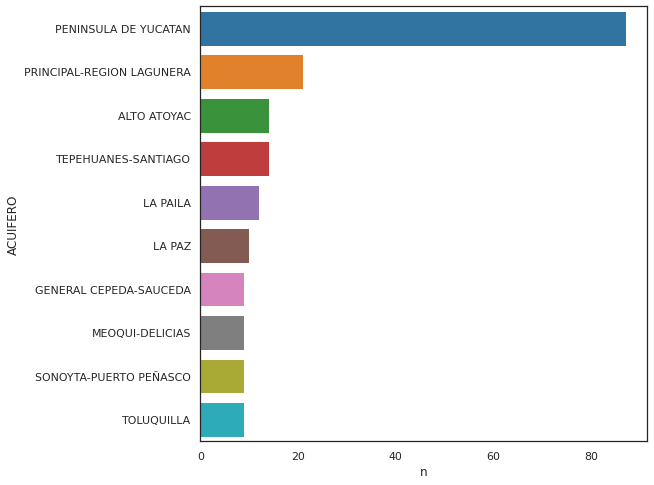

Valores únicos:
(Sólo los primeros 10 valores)
+---------------------------+------------+
|                           |   ACUIFERO |
|---------------------------+------------|
| PENINSULA DE YUCATAN      |         87 |
| PRINCIPAL-REGION LAGUNERA |         21 |
| ALTO ATOYAC               |         14 |
| TEPEHUANES-SANTIAGO       |         14 |
| LA PAILA                  |         12 |
| LA PAZ                    |         10 |
| GENERAL CEPEDA-SAUCEDA    |          9 |
| MEOQUI-DELICIAS           |          9 |
| SONOYTA-PUERTO PEÑASCO    |          9 |
| TOLUQUILLA                |          9 |
+---------------------------+------------+


In [ ]:
analizar_variable({
    'column': 'ACUIFERO',
    'dict_key': 'ACUIFERO',
    'type': 'category',
})

Encontramos que nuestras muestras pertenecen a varios acuiferos; el más relevante en cuestión de números es el de la península de Yucatán, seguido por la Región lagunera y así sucesivamente. Esta variable por si misma sólo nos habla de la distribución de la muestra.

### Organismo de Cuenca


    -----------------------------------------
    Variable: ORGANISMO_DE_CUENCA
    -----------------------------------------
    Descripcion: Nombre del Organismo de Cuenca de agua donde se localiza el sitio de monitoreo
    Tipo: category
    Nulos: 0
    
    
(Sólo los primeros 10 valores)


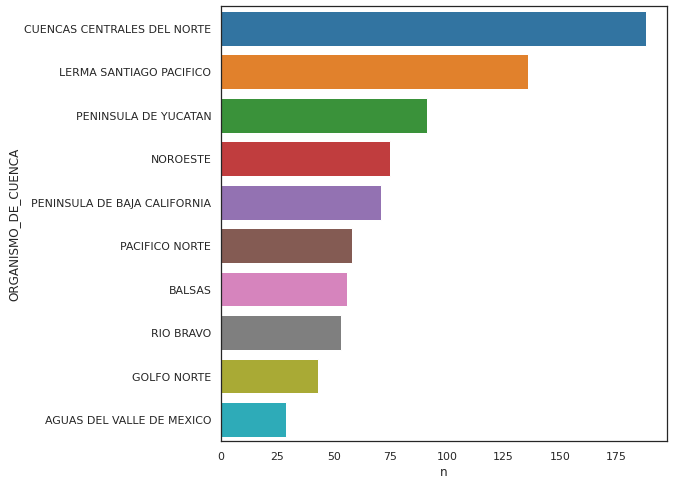

Valores únicos:
(Sólo los primeros 10 valores)
+------------------------------+-----------------------+
|                              |   ORGANISMO_DE_CUENCA |
|------------------------------+-----------------------|
| CUENCAS CENTRALES DEL NORTE  |                   188 |
| LERMA SANTIAGO PACIFICO      |                   136 |
| PENINSULA DE YUCATAN         |                    91 |
| NOROESTE                     |                    75 |
| PENINSULA DE BAJA CALIFORNIA |                    71 |
| PACIFICO NORTE               |                    58 |
| BALSAS                       |                    56 |
| RIO BRAVO                    |                    53 |
| GOLFO NORTE                  |                    43 |
| AGUAS DEL VALLE DE MEXICO    |                    29 |
+------------------------------+-----------------------+


In [ ]:
analizar_variable({
    'column': 'ORGANISMO_DE_CUENCA',
    'dict_key': 'NOMBRE_ORGANISMO_DE_CUENCA',
    'type': 'category',
})

Podemos realizar un análisis similar con las cuencas en donde las centrales del norte son las de mayor incidencia, seguidas por Lerma Santiago PAcífico. No hay mucho que inferir aquí tampoco.

### Subtipo


    -----------------------------------------
    Variable: SUBTIPO
    -----------------------------------------
    Descripcion: Descripción no encontrada en diccionario.
    Tipo: category
    Nulos: 0
    
    
(Sólo los primeros 10 valores)


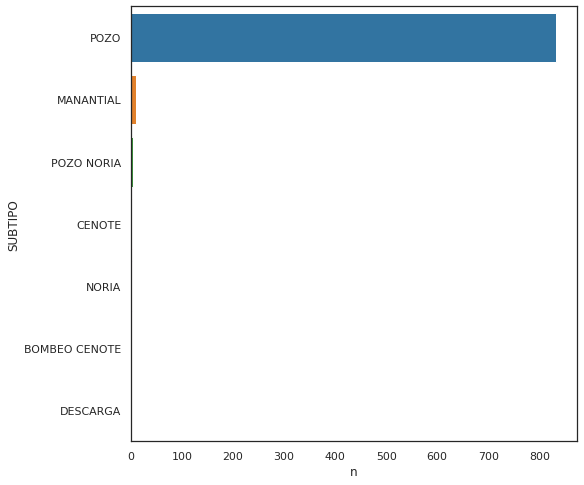

Valores únicos:
(Sólo los primeros 10 valores)
+---------------+-----------+
|               |   SUBTIPO |
|---------------+-----------|
| POZO          |       833 |
| MANANTIAL     |        10 |
| POZO NORIA    |         4 |
| CENOTE        |         3 |
| NORIA         |         2 |
| BOMBEO CENOTE |         1 |
| DESCARGA      |         1 |
+---------------+-----------+


In [ ]:
analizar_variable({
    'column': 'SUBTIPO',
    'type': 'category',
})

En su mayoría todo viene de Pozos, un poco de manantial y luego se divide todo en otros 6 subtipos; el simple desbalanceo que existe en donde la gran mayoría (97.6%) es de subtipo pozo nos invita a no hacer un mayor análisis aquí.

### Estado, Municipio, Latitud y Longitud

Ahora si, pasemos a una parte más visual; sabemos que cada muestra viene de un lugar de la república mexicana y por lo tanto es posible ubicarlo en estados, municipios e incluso puntos exactos por longitud y latitud.

Creemos primero conjuntos de entrenamiento basados sólo en la longitud y latitud para nuestro análisis geográfico:

In [ ]:
# Crear dataframe de datos geográficos:
geo_features = ["LONGITUD","LATITUD"]

# Y su correspondiente parte de entrenamiento:
geo_train = X_train.loc[: , geo_features]

# Además tomemos los colores de semáforo de cada locación:

geo_train["SEMAFORO"] = y_train["SEMAFORO"]

# Y una adicional para transformaciones de colores y etiquetas:
geo_train["DESC_SEMAFORO"] = y_train["SEMAFORO"]

# Observemos nuestro conjunto:
geo_train.head()

,LONGITUD,LATITUD,SEMAFORO,DESC_SEMAFORO
910,-114.904922,32.321953,Verde,Verde
944,-106.817410,23.921070,Verde,Verde
567,-102.311340,22.770010,Rojo,Rojo
106,-104.345890,26.751790,Rojo,Rojo
587,-102.394690,23.785910,Rojo,Rojo


Generamos un conjunto GeoDataFrame para seguir con el análisis:

In [ ]:
# crear con coordenadas:
geo_train["COORDENADAS"] = list(zip(geo_train.LONGITUD, geo_train.LATITUD,))
geo_train["COORDENADAS"] = geo_train.loc[:, "COORDENADAS"].apply(Point)
gdf = gpd.GeoDataFrame(geo_train, geometry="COORDENADAS")

# Observemos el conjunto ya con coordenadas:
gdf.head()

,LONGITUD,LATITUD,SEMAFORO,DESC_SEMAFORO,COORDENADAS
910,-114.904922,32.321953,Verde,Verde,POINT (-114.90492 32.32195)
944,-106.817410,23.921070,Verde,Verde,POINT (-106.81741 23.92107)
567,-102.311340,22.770010,Rojo,Rojo,POINT (-102.31134 22.77001)
106,-104.345890,26.751790,Rojo,Rojo,POINT (-104.34589 26.75179)
587,-102.394690,23.785910,Rojo,Rojo,POINT (-102.39469 23.78591)


Tomemos también datos para hacer nuestro mapa para ubicar cada punto

In [ ]:
# Datos para mapa:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

Definamos los colores del semaforo en términos que pueda usar la libreria:

In [ ]:
# semáforo de colores interpretrables para graficar
def funMapColor(df):
  df['SEMAFORO'] = df.loc[: ,'SEMAFORO'].map({ 'Verde':'Green', 'Rojo':'Red', 'Amarillo':'Yellow'})
  return df 

funMapColor(geo_train)

,LONGITUD,LATITUD,SEMAFORO,DESC_SEMAFORO,COORDENADAS
910,-114.904922,32.321953,Green,Verde,POINT (-114.90492 32.32195)
944,-106.817410,23.921070,Green,Verde,POINT (-106.81741 23.92107)
567,-102.311340,22.770010,Red,Rojo,POINT (-102.31134 22.77001)
106,-104.345890,26.751790,Red,Rojo,POINT (-104.34589 26.75179)
587,-102.394690,23.785910,Red,Rojo,POINT (-102.39469 23.78591)
...,...,...,...,...,...
330,-98.715230,20.306080,Red,Rojo,POINT (-98.71523 20.30608)
466,-100.763040,21.612920,Red,Rojo,POINT (-100.76304 21.61292)
121,-100.952750,25.495290,Yellow,Amarillo,POINT (-100.95275 25.49529)
1044,-89.933889,20.962222,Yellow,Amarillo,POINT (-89.93389 20.96222)


Generemos además etiquetas para la visualización:

In [ ]:
# Etiquetas para el mapa:
def funMapDesc(df):
  df['DESC_SEMAFORO'] = df.loc[:, 'DESC_SEMAFORO'].map({ 'Verde':'Límites aceptables', 'Rojo':'Fuerte Contaminación', 'Amarillo':'Incumplimiento a parámeteros'})
  return df 

funMapDesc(geo_train)

,LONGITUD,LATITUD,SEMAFORO,DESC_SEMAFORO,COORDENADAS
910,-114.904922,32.321953,Green,Límites aceptables,POINT (-114.90492 32.32195)
944,-106.817410,23.921070,Green,Límites aceptables,POINT (-106.81741 23.92107)
567,-102.311340,22.770010,Red,Fuerte Contaminación,POINT (-102.31134 22.77001)
106,-104.345890,26.751790,Red,Fuerte Contaminación,POINT (-104.34589 26.75179)
587,-102.394690,23.785910,Red,Fuerte Contaminación,POINT (-102.39469 23.78591)
...,...,...,...,...,...
330,-98.715230,20.306080,Red,Fuerte Contaminación,POINT (-98.71523 20.30608)
466,-100.763040,21.612920,Red,Fuerte Contaminación,POINT (-100.76304 21.61292)
121,-100.952750,25.495290,Yellow,Incumplimiento a parámeteros,POINT (-100.95275 25.49529)
1044,-89.933889,20.962222,Yellow,Incumplimiento a parámeteros,POINT (-89.93389 20.96222)


Ya estamos listos, ahora veamos como se ve nuestro mapa con cada ubicación dibujada acorde al semáforo de calidad.

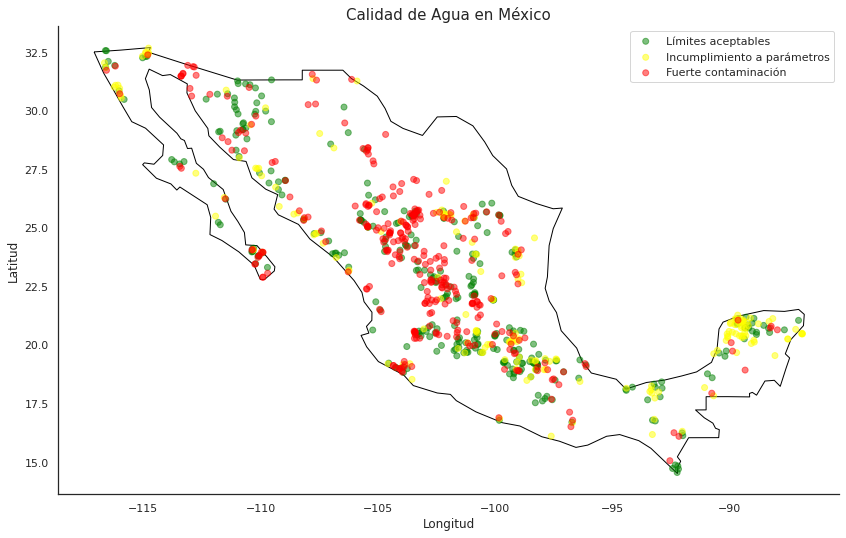

In [ ]:
############################################################################################
# Primer mapa exploraorio:
############################################################################################

# Empecemos el canvas:
fig, ax = plt.subplots(figsize=(14,18))

# Generemos un mapa en blanco de México
world.query("name == 'Mexico'").plot(ax=ax, edgecolor='black', color='white')

# Ahora tomemos cada conjunto acorde a su color en el semáforo
green_  = gdf[gdf.SEMAFORO == 'Green']
yellow_ = gdf[gdf.SEMAFORO == 'Yellow']
red_ = gdf[gdf.SEMAFORO == 'Red']

# Mandemos cada punto al mapa en blanco:
green_.plot(ax=ax, color = green_.SEMAFORO, alpha = 0.5, label = 'Límites aceptables')
yellow_.plot(ax=ax, color = yellow_.SEMAFORO, alpha = 0.5, label = 'Incumplimiento a parámetros')
red_.plot(ax=ax, color = red_.SEMAFORO, alpha = 0.5, label = 'Fuerte contaminación')

# Agreguemos algunos textos adicionales:
ax.legend()
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_title('Calidad de Agua en México',fontsize = 15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Y grafiquemos:
plt.show()

Observando el mapa de México, los datos muestran que la calidad del agua presenta elevados niveles de contaminación en la mayoría de las ubicaciones geográficas. El sur de México en su península muestra que hay la calidad del agua también es deficiente y con riesgo a presentar elevados de contaminación.Existen algunos puntos en donde la calidad es aceptable, sin embargo no se observa una gran concentración de estos puntos.

El problema actual es que tenemos bastantes puntos, más de 800, esto crearía sobre entrenamiento si procedemos con esto como predictor; quizás entonces debemos agruparlos para reducir su complejidad, para esto usaremos K-Means. Comencemos por definir un "número optimo:

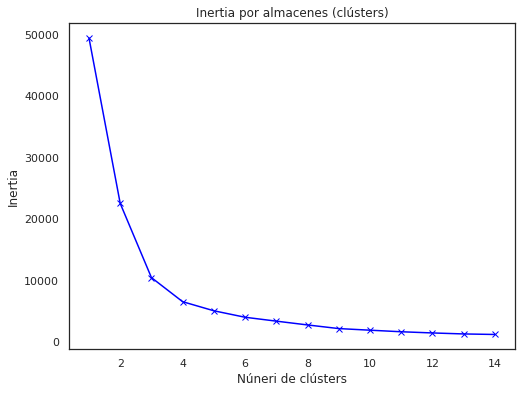

In [ ]:
############################################################################################
# Aplicando y buscando los centroides óptimos para K-Means:
############################################################################################

# Creemos una lista para almacenar los clústers y medir su desempeño:
inertia_list = list()

# Número de clústers a evaluar:
clusters = range(1,15)

# Veamos los diferentes desempeños obtenidos en el rango de clústers.
for k in clusters:
    # definamos un modelo K-means
    KM = KMeans(n_clusters=k)
    # entrenemos
    KM.fit(geo_train[['LONGITUD', 'LATITUD']])
    # Inertia: como la suma de los errores cuadrados de las obseraciones con respecto a los centroides
    inertia_list.append(KM.inertia_)

# Grafiquemos el desempeño
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(clusters, inertia_list, 'bx-')
plt.xlabel('Núneri de clústers')
plt.ylabel('Inertia')
plt.title('Inertia por almacenes (clústers)')
plt.show()

Aunque el método de codo sugiere utilizar 4, vemos también que la marginalidad no comienza sino hasta después de 6. Tomemos ese número como nuestro número optimo y creemos un modelo con eso.

In [ ]:
# Definamos un modelo K-means de 6 clústers:
KM = KMeans(n_clusters=6)

# Entrenamos el modelo:
KM.fit(geo_train[['LONGITUD', 'LATITUD']])

# Obtengamos e imprimamos los datos:
for i, K in enumerate(KM.cluster_centers_):
  print(f"El clúster geográfico {i} se ubica en: latitud {K[0]:.3f}, y longitud {K[1]:.3f}")

El clúster geográfico 0 se ubica en: latitud -103.644, y longitud 25.318
El clúster geográfico 1 se ubica en: latitud -90.085, y longitud 19.625
El clúster geográfico 2 se ubica en: latitud -112.505, y longitud 30.486
El clúster geográfico 3 se ubica en: latitud -98.533, y longitud 19.175
El clúster geográfico 4 se ubica en: latitud -101.851, y longitud 21.488
El clúster geográfico 5 se ubica en: latitud -109.256, y longitud 25.220


In [ ]:
# Ahora agreguemos los clústers a nuestro conjunto:
geo_train["cluster"] = KM.predict(geo_train.loc[:, ['LONGITUD', 'LATITUD']])
gdf["cluster"] = KM.predict(gdf.loc[:, ['LONGITUD', 'LATITUD']])
gdf.head()

,LONGITUD,LATITUD,SEMAFORO,DESC_SEMAFORO,COORDENADAS,cluster
910,-114.904922,32.321953,Green,Límites aceptables,POINT (-114.90492 32.32195),2
944,-106.817410,23.921070,Green,Límites aceptables,POINT (-106.81741 23.92107),5
567,-102.311340,22.770010,Red,Fuerte Contaminación,POINT (-102.31134 22.77001),4
106,-104.345890,26.751790,Red,Fuerte Contaminación,POINT (-104.34589 26.75179),0
587,-102.394690,23.785910,Red,Fuerte Contaminación,POINT (-102.39469 23.78591),0


In [ ]:
# También guardamos la información de nuestros clústers para después:
cluster_df = pd.DataFrame(KM.cluster_centers_)
cluster_df["Coordenadas"] = list(zip(cluster_df[0], cluster_df[1]))
cluster_df["Coordenadas"] = cluster_df["Coordenadas"].apply(Point)
gdf_clusters = gpd.GeoDataFrame(cluster_df, geometry="Coordenadas") 

gdf_clusters.head()

,0,1,Coordenadas
0,-103.643711,25.317511,POINT (-103.64371 25.31751)
1,-90.085181,19.625021,POINT (-90.08518 19.62502)
2,-112.505199,30.485693,POINT (-112.50520 30.48569)
3,-98.532832,19.175276,POINT (-98.53283 19.17528)
4,-101.851247,21.487784,POINT (-101.85125 21.48778)


¡Tenemos la información necesaria! Ahora graficaremos todos nuestros puntos de agua; su color de contaminación y mostraremos los conjuntos obtenidos por nuestro K-Means

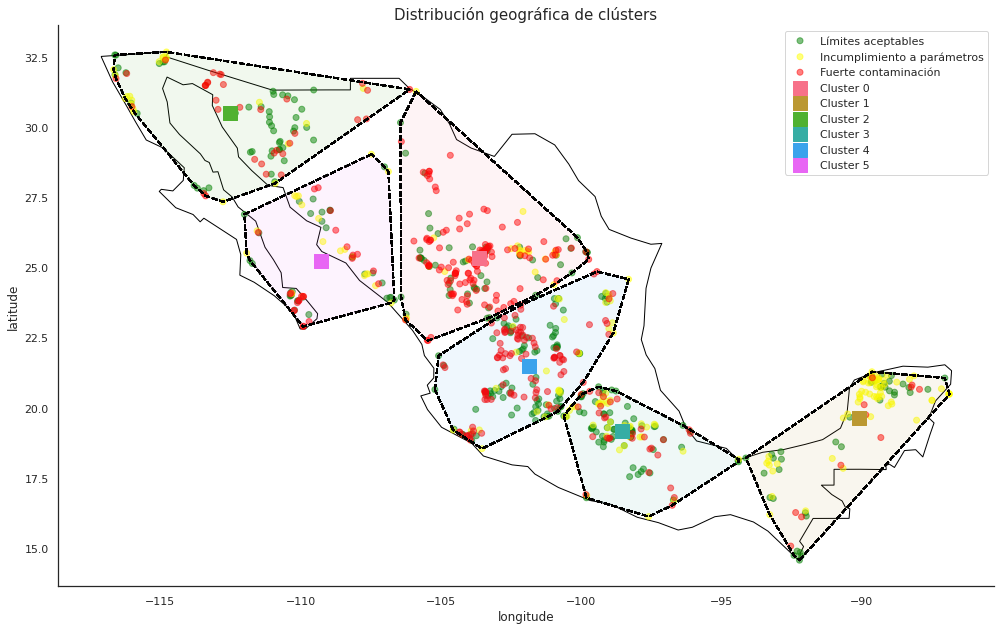

In [ ]:
############################################################################################
# Mapa con K-Means
############################################################################################

# Primero definamos una función para graficar envolutras convexas basada en los puntos de cada clúster:
def drawclusters(ax):
    # Cada cluster de color diferente:
    palette = iter(sns.husl_palette(KM.n_clusters))
    # Iteremos sobre cada clúster:
    for i in range(KM.n_clusters):
      # obtenemos los valores de longitud y latitud de cada subconjunto:
      # colors:
      cluster_color = next(palette)

      sub_gdf = gdf[gdf['cluster'] == i]
      sub_gdf = sub_gdf[['LONGITUD', 'LATITUD']].values

      # E iteramos sobre estos subconjuntos:
      for j in range(len(sub_gdf)):
          # Obtenemos los puntos:
          points = sub_gdf
          # Y creamos la envolutra convexa:
          hull = ConvexHull(points)
          # Y obtenemos los puntos de unión de ellos:
          vert = np.append(hull.vertices, hull.vertices[0])
          # Para gráficar con esto nuestro poligono:
          ax.plot(points[vert, 0], points[vert, 1], '--', c='black')
      
      # Y cada clúster, pongamos con un leve tono de fondo
      ax.scatter(KM.cluster_centers_[i, 0], KM.cluster_centers_[i, 1], s=200, color=cluster_color, label='Cluster ' + str(i) , marker='s')
      plt.fill(points[hull.vertices,0], points[hull.vertices,1], color=cluster_color, alpha=0.08)

# Ahora grafiquemos de nuevo todos los puntos que ya teniamos:
fig, ax = plt.subplots(figsize=(14,18))
world.query("name == 'Mexico'").plot(ax = ax, edgecolor='black', color='white')
green_  = gdf[gdf.SEMAFORO == 'Green']
yellow_ = gdf[gdf.SEMAFORO == 'Yellow']
red_ = gdf[gdf.SEMAFORO == 'Red']
green_.plot(ax=ax, color = green_.SEMAFORO, alpha = 0.5, label = "Límites aceptables")
yellow_.plot(ax=ax, color = yellow_.SEMAFORO, alpha = 0.5, label = "Incumplimiento a parámetros")
red_.plot(ax=ax, color = red_.SEMAFORO, alpha = 0.5, label = "Fuerte contaminación")

# Y dibujemos los poligonos por envoltura convexa:
drawclusters(ax)

# Etiquetas
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('Distribución geográfica de clústers', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend()
plt.tight_layout()
plt.show()

¡Ahora esto sí sirve!
Observamos aquí que la mayoría de la contaminación se encuentra en parte de la Zona Noreste (0) y Zona Centro Norte del país (4); la Zona Centro Sur (3) pese a tener varios puntos rojos también tiene buenas concentraciones verdes y existe, al parecer, menor contaminación en la parte Zona Suroeste (2) del país.

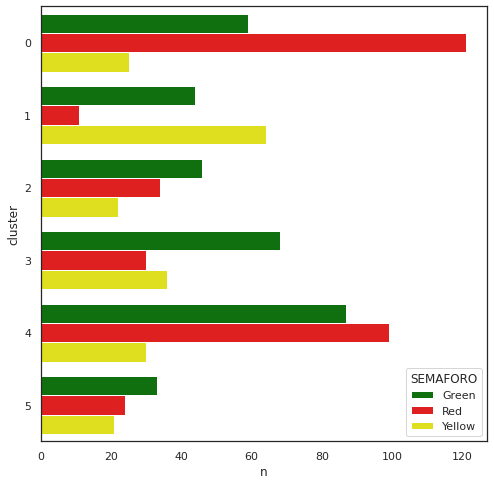

In [ ]:
# Primero agrupemos los datos:
df_cluster = (
    gdf
    .groupby(['cluster', 'SEMAFORO'])
    .size()
    .reset_index(name='n')
    .fillna(0)
)

# Grafiquemos nuestros clusters:
fig, ax = plt.subplots(figsize=(8,8))

# 3 gráficas: un boxplot general, un histograma de los datos y luego un boxplot de la variable objetivo:
sns.barplot(data=df_cluster, x='n', y='cluster', orient='h', hue='SEMAFORO', palette={ 'Green': 'green', 'Red': 'red', 'Yellow': 'yellow'}, ax=ax)
plt.show()

Esto conserva que cluster 0 (Zona Noreste) es la más contaminada, seguida por el clúster 4 (Zona Centro-Norte) ya de una forma más análitica. Esto sugeriria que nuevos pozos encontrados en esta zona podrían tener esta misma característica.

## Contaminantes

Ordenando el diccionario y haciendo un *match* manual con los valores que tenemos en las columnas encontramos 14 mediciones, usaremos la función de análisis en cada una de estas para medir tanto sus valores como su calidad y cumplimiento. Después de esto haremos un cruzado para observar correlación entre las diferentes mediciones de contaminación.

<h3> Variables de contaminación </h3>
<table>
<thead>
  <tr>
    <th>Variable</th>
    <th>Métrica</th>
    <th>Descripción</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td rowspan="3">Alcalinidad</td>
    <td>ALC_mg/L</td>
    <td>Valor de Alcalinidad Total, en miligramos por litro	</td>
  </tr>
  <tr>
    <td>CALIDAD_ALC</td>
    <td>Clasificacion de la calidad del agua de acuerdo con el indicador Alcalinidad Total</td>
  </tr>
  <tr>
    <td>CUMPLE_CON_ALC</td>
    <td>Indica si cumple con la calidad de Baja, Media, o Alta para el Indicador Alcalinidad Total</td>
  </tr>
  <tr>
    <td rowspan="3">Arsenico</td>
    <td>AS_TOT_mg/L</td>
    <td>Valor de Arsenico Total, en miligramos por litro</td>
  </tr>
  <tr>    
    <td>CALIDAD_AS</td>
    <td>Clasificacion de la calidad del agua de acuerdo con el indicador Arsenico Total</td>
  </tr>
  <tr>
    <td>CUMPLE_CON_AS</td>
    <td>Indica si cumple con la calidad de Potable - Excelente o Apta como FAAP, para el Indicador Arsenico Total</td>
  </tr>
  <tr>
    <td rowspan="3">Cadmio</td>
    <td>CD_TOT_mg/L</td>
    <td>Valor de Cadmio Total, en miligramos por litro</td>
  </tr>
  <tr>
    <td>CALIDAD_CD</td>
    <td>Clasificacion de la calidad del agua de acuerdo con el indicador Cadmio Total</td>
  </tr>
  <tr>
    <td>CUMPLE_CON_CD</td>
    <td>Indica si cumple con la calidad de Potable - Excelente, para el Indicador Cadmio Total</td>
  </tr>  
  <tr>
    <td rowspan="3">Coliformes fecales</td>
    <td>COLI_FEC_NMP/100_mL</td>
    <td>Valor de Coliformes Fecales, en Numero Mas Probable por 100 mililitros</td>
  </tr>
  <tr>
    <td>CALIDAD_COLI_FEC</td>
    <td>Clasificacion de la calidad del agua de acuerdo con el indicador Coliformes Fecales</td>
  </tr>
  <tr>
    <td>CUMPLE_CON_CF</td>
    <td>Indica si cumple con la calidad de Potable - Excelente, o Buena calidad, Aceptable, para el Indicador Coliformes Fecales</td>
  </tr>
  <tr>
    <td rowspan="3">Conductividad</td>
    <td>CONDUCT_mS/cm</td>
    <td>Valor de Conductividad en microSiemens por centimetro</td>
  </tr>
  <tr>
    <td>CALIDAD_CONDUC</td>
    <td>	Clasificacion de la calidad del agua de acuerdo con el indicador Conductividad</td>
  </tr>
  <tr>
    <td>CUMPLE_CON_COND</td>
    <td>	Indica si cumple con la calidad de Excelente para riego, Buena para riego, o Permisible para riego, para el Indicador Conductividad</td>
  </tr>
  <tr>
    <td rowspan="3">Cromo</td>
    <td>CR_TOT_mg/L</td>
    <td>Valor de Cromo Total, en miligramos por litro</td>
  </tr>
  <tr>
    <td>CALIDAD_CR</td>
    <td>Clasificacion de la calidad del agua de acuerdo con el indicador Cromo Total</td>
  </tr>
  <tr>
    <td>CUMPLE_CON_CR</td>
    <td>Indica si cumple con la calidad de Potable - Excelente, para el Indicador Cromo Total</td>
  </tr>
  <tr>
    <td rowspan="3">Dureza</td>
    <td>DUR_mg/L</td>
    <td>Valor de Dureza Total, en miligramos por litro</td>
  </tr>
  <tr>
    <td>CALIDAD_DUR</td>
    <td>Clasificacion de la calidad del agua de acuerdo con el indicador Dureza Total</td>
  </tr>
  <tr>
    <td>CUMPLE_CON_DUR</td>
    <td>Indica si cumple con la calidad de Potable - Suave, Potable - Moderadamente suave, o Potable - Dura, para el Indicador Dureza Total</td>
  </tr>
  <tr>
    <td rowspan="3">Fluoruros</td>
    <td>FLUORUROS_mg/L</td>
    <td>Valor de Fluoruros Totales (F-), en miligramos por litro</td>
  </tr>
  <tr>
    <td>CALIDAD_FLUO</td>
    <td>Clasificacion de la calidad del agua de acuerdo con el indicador Fluoruros Totales</td>
  </tr>
  <tr>
    <td>CUMPLE_CON_FLUO</td>
    <td>Indica si cumple con la calidad de Baja, Media, o Potable - Optima, para el Indicador Fluoruros Totales</td>
  </tr>
  <tr>
    <td rowspan="3">Hierro</td>
    <td>FE_TOT_mg/L</td>
    <td>Valor de Hierro Total, en miligramos por litro</td>
  </tr>
  <tr>
    <td>CALIDAD_FE</td>
    <td>Clasificacion de la calidad del agua de acuerdo con el indicador Hierro Total</td>
  </tr>
  <tr>
    <td>CUMPLE_CON_FE</td>
    <td>Indica si cumple con la calidad de Potable - Excelente, para el Indicador Hierro Tota</td>
  </tr>
  <tr>
    <td rowspan="3">Manganesio</td>
    <td>MN_TOT_mg/L</td>
    <td>Valor de Manganeso Total, en miligramos por litro</td>
  </tr>
  <tr>
    <td>CALIDAD_MN</td>
    <td>Clasificacion de la calidad del agua de acuerdo con el indicador Manganeso Total</td>
  </tr>
  <tr>
    <td>CUMPLE_CON_MN</td>
    <td>Indica si cumple con la calidad de Potable - Excelente, para el Indicador Manganeso Total</td>
  </tr>          
  <tr>
    <td rowspan="3">Mercurio</td>
    <td>HG_TOT_mg/L</td>
    <td>Valor de Mercurio Total, en miligramos por litro</td>
  </tr>
  <tr>
    <td>CALIDAD_HG</td>
    <td>Clasificacion de la calidad del agua de acuerdo con el indicador Mercurio Tota</td>
  </tr>
  <tr>
    <td>CUMPLE_CON_HG</td>
    <td>Indica si cumple con la calidad de Potable - Excelente, para el Indicador Mercurio Total</td>
  </tr>  
  <tr>
    <td rowspan="3">Nitrogeno de Nitratos</td>
    <td>N_NO3_mg/L</td>
    <td>Valor de Nitrogeno de Nitratos, en miligramos por litro</td>
  </tr>
  <tr>
    <td>CALIDAD_N_NO3</td>
    <td>Clasificacion de la calidad del agua de acuerdo con el indicador Nitrogeno de Nitratos</td>
  </tr>
  <tr>
    <td>CUMPLE_CON_NO3</td>
    <td>	Indica si cumple con la calidad de Potable - Excelente o Potable - Buena calidad, para el Indicador Nitrogeno de Nitratos</td>
  </tr>  
  <tr>
    <td rowspan="3">Plomo</td>
    <td>PB_TOT_mg/L</td>
    <td>Valor de Plomo Total, en miligramos por litro</td>
  </tr>
  <tr>
    <td>CALIDAD_PB</td>
    <td>Clasificacion de la calidad del agua de acuerdo con el indicador Plomo Total</td>
  </tr>
  <tr>
    <td>CUMPLE_CON_PB</td>
    <td>Indica si cumple con la calidad de Potable - Excelente, para el Indicador Plomo Total</td>
  </tr>  
  <tr>
    <td rowspan="5">Soliduos disueltos</td>
    <td>SDT_M_mg/L</td>
    <td>	Valor de Solidos Disueltos Totales-Medidos, en miligramos por litro</td>
  </tr>
  <tr>
    <td>CALIDAD_SDT_ra</td>
    <td>Clasificacion de la calidad del agua de acuerdo con el indicador de los Solidos Disueltos Totales (Riego agricola)</td>
  </tr>
  <tr>
    <td>CUMPLE_CON_SDT_ra</td>
    <td>Indica si cumple con la calidad de Excelente para riego, Cultivos sensibles o Cultivos con manejo especial, para el Indicador SDT (Riego agr­cola)</td>
  </tr>
  <tr>
    <td>CALIDAD_SDT_salin</td>
    <td>Clasificacion de la calidad del agua de acuerdo con el indicador de los Solidos Disueltos Totales (Salinizacion)</td>
  </tr>
  <tr>
    <td>CUMPLE_CON_SDT_salin</td>
    <td>Indica si cumple con la calidad de Potable - Dulce o Ligeramente salobres, para el Indicador Solidos Disueltos Totales (Salinizaci½n)</td>
  </tr>
</tbody>
</table>

Con nuestra función de análisis mediremos sus medidas, rangos de calidad y resistencia así como superficialmente su relación con el samaforo de la calidad del agua

### Alcalinidad


    -----------------------------------------
    Variable: ALC_mg/L
    -----------------------------------------
    Descripcion: Valor de Alcalinidad Total, en miligramos por litro
    Tipo: number
    Nulos: 4
    
    


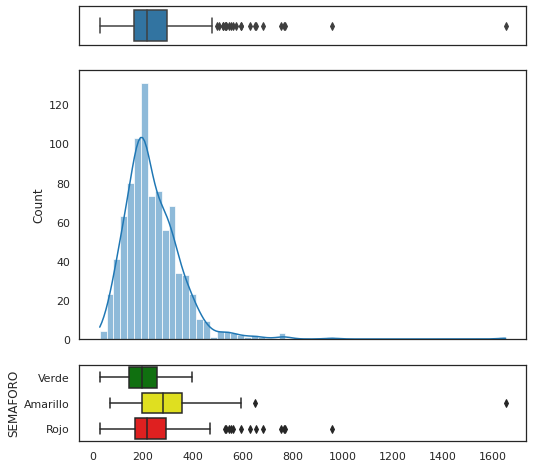

+----------+---------+---------+----------+-------+---------+--------+---------+--------+
|          |   count |    mean |      std |   min |     25% |    50% |     75% |    max |
|----------+---------+---------+----------+-------+---------+--------+---------+--------|
| ALC_mg/L |     850 | 236.897 | 117.823  | 26.64 | 164.46  | 214.81 | 297     | 1650   |
| Verde    |     335 | 200.11  |  78.5658 | 28.86 | 143.975 | 193.87 | 257.555 |  397.1 |
| Amarillo |     198 | 287.74  | 144.932  | 66.6  | 197.58  | 280.4  | 355.265 | 1650   |
| Rojo     |     317 | 244.017 | 120.719  | 26.64 | 168.72  | 215    | 291.28  |  954.6 |
+----------+---------+---------+----------+-------+---------+--------+---------+--------+


In [ ]:
analizar_variable({
    'column': 'ALC_mg/L',
    'dict_key': 'ALC_mg/L',
    'type': 'number',
})

Considerando los no nulos, observamos valores entre 26.64 y 1650, con una media de 237 y una desviación de 117 en la alcalinidad; estos se dividen en proporciones relativamente balanceadas con respecto al semáforo. Encontramos 4 nulos puros.


    -----------------------------------------
    Variable: CUMPLE_CON_ALC
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Baja, Media, o Alta para el Indicador Alcalinidad Total
    Tipo: classification
    Nulos: 0
    
    


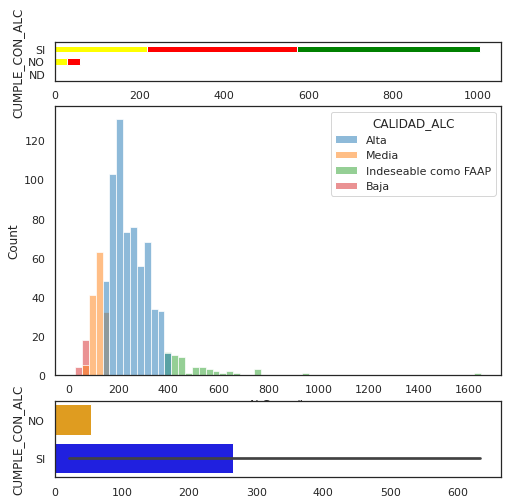

+----+----------------------+----------+---------+---------+----------+---------+
|    | calidad              | cumple   |   count |     min |     mean |     max |
|----+----------------------+----------+---------+---------+----------+---------|
|  0 | Baja                 | SI       |      22 |  26.64  |  60.3543 |   73.26 |
|  1 | Media                | SI       |     141 |  75.555 | 118.592  |  150    |
|  2 | Alta                 | SI       |     633 | 150.015 | 245.036  |  399.6  |
|  3 | Indeseable como FAAP | NO       |      54 | 400.77  | 522.326  | 1650    |
+----+----------------------+----------+---------+---------+----------+---------+


In [ ]:
analizar_variable({
    'column': 'CUMPLE_CON_ALC',
    'dict_key': 'CUMPLE_CON_ALC',
    'type': 'classification',
    'classification_dict': {'value': 'ALC_mg/L', 'class': 'CALIDAD_ALC'}
})

La anterior relación sugiere una relación numérica para la alcalinidad donde ⪆ 400 es indeseable y no cumple con la calidad. Nada clasificado como verde en el semáforo incumple; por lo que concluimos que deseamos niveles de alcalanidad ⪅ a 400, idealmente ⪆ 150 para alta calidad. En concreto esperamos una alcalinidad entre ⪆ 26 y ⪅ a 400 y en general tenemos más cuerpos con alta alcalinidad que de otra clase (⪆ 150 y ⪅ 400) con 633.

### Arsénico


    -----------------------------------------
    Variable: AS_TOT_mg/L
    -----------------------------------------
    Descripcion: Valor de Arsenico Total, en miligramos por litro 
    Tipo: pseudonumber
    Nulos: 652
    NaN: ['<0.01']
    


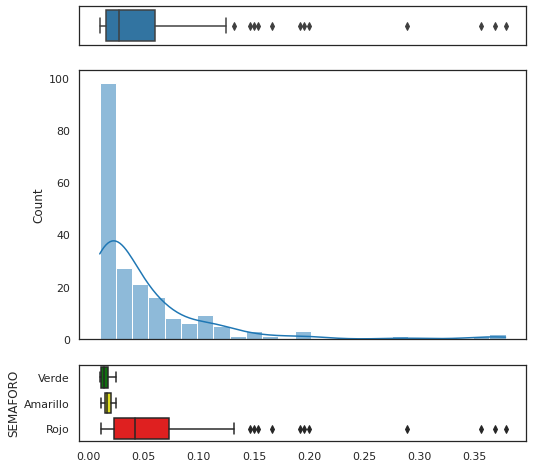

+-------------+---------+-----------+------------+--------+----------+---------+----------+--------+
|             |   count |      mean |        std |    min |      25% |     50% |      75% |    max |
|-------------+---------+-----------+------------+--------+----------+---------+----------+--------|
| AS_TOT_mg/L |     202 | 0.0490461 | 0.0578477  | 0.01   | 0.0158   | 0.02725 | 0.0605   | 0.3784 |
| Verde       |      40 | 0.0147012 | 0.00408362 | 0.01   | 0.011175 | 0.01395 | 0.017075 | 0.0246 |
| Amarillo    |      16 | 0.0173006 | 0.00425717 | 0.0107 | 0.014575 | 0.0166  | 0.020525 | 0.025  |
| Rojo        |     146 | 0.0619346 | 0.0634707  | 0.0108 | 0.023375 | 0.0423  | 0.07265  | 0.3784 |
+-------------+---------+-----------+------------+--------+----------+---------+----------+--------+


In [ ]:
analizar_variable({
    'column': 'AS_TOT_mg/L',
    'dict_key': 'AS_TOT_mg/L',
    'type': 'pseudonumber',
})

Considerando los no nulos, observamos valores entre 0.01 y 0.37 en arsénico, con una media de 0.049 y una desviación de 0.05; se observa una clara tendencia al semáforo rojo cuando la presencia de arsénico es alta. Encontramos 652 nulos clasificados como <0.01 lo que los ubicaría en los valores míinimos y probablemente verdes con respecto al semáforo.

In [ ]:
df.to_excel("output.xlsx")


    -----------------------------------------
    Variable: CUMPLE_CON_AS
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente o Apta como FAAP, para el Indicador Arsenico Total 
    Tipo: classification
    Nulos: 0
    
    


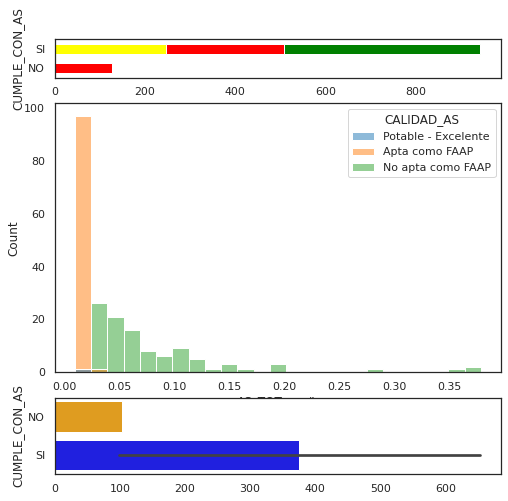

+----+---------------------+----------+---------+--------+-------------+--------+
|    | calidad             | cumple   |   count |    min |        mean |    max |
|----+---------------------+----------+---------+--------+-------------+--------|
|  0 | Potable - Excelente | SI       |     653 | 0      | 1.53139e-05 | 0.01   |
|  1 | Apta como FAAP      | SI       |      98 | 0.0101 | 0.0165511   | 0.025  |
|  2 | No apta como FAAP   | NO       |     103 | 0.0252 | 0.0803427   | 0.3784 |
+----+---------------------+----------+---------+--------+-------------+--------+


In [ ]:
analizar_variable({
    'column': 'CUMPLE_CON_AS',
    'dict_key': 'CUMPLE_CON_AS',
    'type': 'classification',
    'classification_dict': {'value': 'AS_TOT_mg/L', 'class': 'CALIDAD_AS'}
})

La anterior relación sugiere una relación numérica para el asrénico donde ⪆ 0.025 es indeseable y no cumple con la calidad. Todo lo que incumple se traslada a rojo en el semáforo; por lo que concluimos que deseamos niveles de arsénico ⪅ a 0.025, idealmente ⪅ 0.01 para ser potable. En concreto esperamos presencia de arsénico entre ⪆ 0 y ⪅ a 0.025 y en general tenemos más cuerpos con agua potable que de otra clase (⪆ 0 y ⪅ 0.025) con 653.

### Coliformes Fecales


    -----------------------------------------
    Variable: COLI_FEC_NMP/100_mL
    -----------------------------------------
    Descripcion: Valor de Coliformes Fecales, en Numero Mas Probable por 100 mililitros
    Tipo: pseudonumber
    Nulos: 585
    NaN: ['<1.1']
    


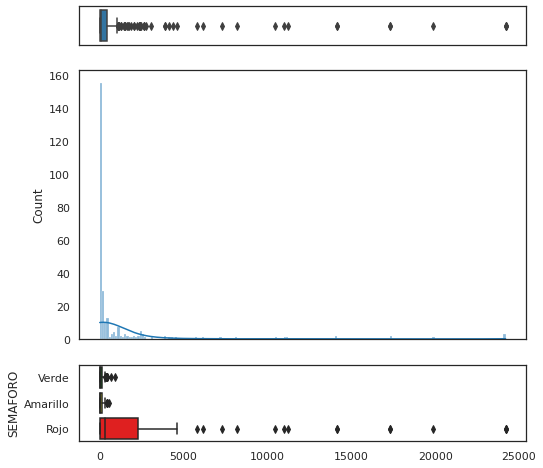

+---------------------+---------+----------+----------+-------+-------+-------+---------+-------+
|                     |   count |     mean |      std |   min |   25% |   50% |     75% |   max |
|---------------------+---------+----------+----------+-------+-------+-------+---------+-------|
| COLI_FEC_NMP/100_mL |     269 | 1208.99  | 3627.92  |     3 | 20    |  90   |  448    | 24196 |
| Verde               |      81 |  118.136 |  161.207 |     3 | 20    |  41   |  146    |   908 |
| Amarillo            |      60 |  108.583 |  144.806 |     4 | 10.75 |  40   |  152.25 |   530 |
| Rojo                |     128 | 2415.11  | 4995.12  |     4 | 40    | 332.5 | 2275    | 24196 |
+---------------------+---------+----------+----------+-------+-------+-------+---------+-------+


In [ ]:
analizar_variable({
    'column': 'COLI_FEC_NMP/100_mL',
    'dict_key': 'COLI_FEC_NMP/100_mL',
    'type': 'pseudonumber',
})

Considerando los no nulos, observamos valores entre 3 y 24196 en coliformes fecales, con una media de 1209 y una desviación de 3628; se observa una clara tendencia al semáforo rojo cuando la presencia de coliformes es alta. Encontramos 585 nulos clasificados como <1.1 lo que los ubicaría en los valores míinimos y probablemente verdes con respecto al semáforo.


    -----------------------------------------
    Variable: CUMPLE_CON_CF
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente, o Buena calidad, Aceptable, para el Indicador Coliformes Fecales
    Tipo: classification
    Nulos: 0
    
    


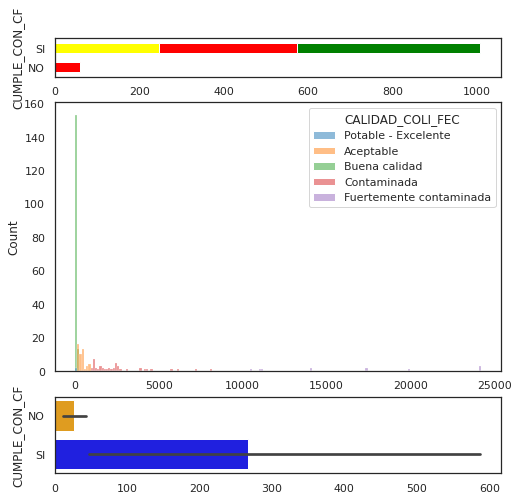

+----+-------------------------+----------+---------+-------+---------------+-------+
|    | calidad                 | cumple   |   count |   min |          mean |   max |
|----+-------------------------+----------+---------+-------+---------------+-------|
|  0 | Potable - Excelente     | SI       |     587 |     0 |     0.0102215 |     3 |
|  1 | Buena calidad           | SI       |     166 |     4 |    48.5181    |   200 |
|  2 | Aceptable               | SI       |      47 |   201 |   404.043     |   908 |
|  3 | Contaminada             | NO       |      43 |  1017 |  2561.07      |  8161 |
|  4 | Fuertemente contaminada | NO       |      11 | 10462 | 17094.7       | 24196 |
+----+-------------------------+----------+---------+-------+---------------+-------+


In [ ]:
analizar_variable({
    'column': 'CUMPLE_CON_CF',
    'dict_key': 'CUMPLE_CON_CF',
    'type': 'classification',
    'classification_dict': {'value': 'COLI_FEC_NMP/100_mL', 'class': 'CALIDAD_COLI_FEC'}
})

La anterior relación sugiere una relación numérica para las partículas coliformes fecales donde ⪆ 908 es indeseable y no cumple con la calidad. Todo lo que incumple se traslada a rojo en el semáforo; por lo que concluimos que deseamos niveles de partículas coliformes fecales ⪅ a 908, idealmente ⪅ 3 para ser potable. En concreto esperamos presencia de partículas coliformes entre ⪆ 0 y ⪅ a 908 y en general tenemos más cuerpos con agua potable alcalinidad que de otra clase (⪆ 0 y ⪅ 3) con 587.

### Conductividad


    -----------------------------------------
    Variable: CONDUCT_mS/cm
    -----------------------------------------
    Descripcion: Valor de Conductividad en microSiemens por centimetro
    Tipo: number
    Nulos: 5
    
    


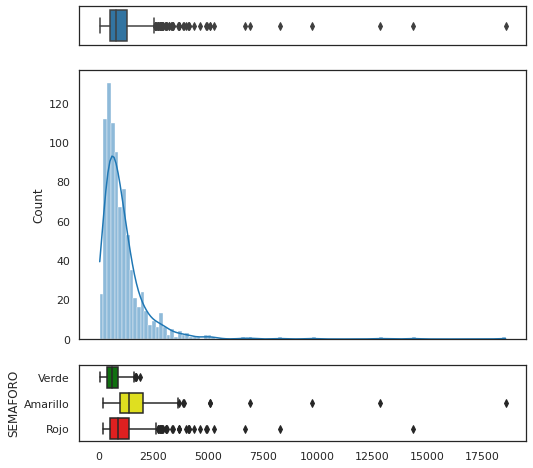

+---------------+---------+----------+----------+-------+--------+--------+---------+-------+
|               |   count |     mean |      std |   min |    25% |    50% |     75% |   max |
|---------------+---------+----------+----------+-------+--------+--------+---------+-------|
| CONDUCT_mS/cm |     849 | 1123.7   | 1270.56  |  50.4 | 499    |  810   | 1309    | 18577 |
| Verde         |     334 |  660.463 |  349.811 |  50.4 | 391.75 |  597.5 |  881    |  1896 |
| Amarillo      |     198 | 1727.33  | 1828.09  | 221   | 968    | 1371.5 | 2030.25 | 18577 |
| Rojo          |     317 | 1234.76  | 1285.4   | 210   | 541    |  872   | 1400    | 14350 |
+---------------+---------+----------+----------+-------+--------+--------+---------+-------+


In [ ]:
analizar_variable({
    'column': 'CONDUCT_mS/cm',
    'dict_key': 'CONDUCT_mS/cm',
    'type': 'number',
})

Considerando los no nulos, observamos valores entre 50.4 y 499 en conductividad, con una media de 1124 y una desviación de 1271; los valores están relativamente balanceados entre los colores del semáforo. Encontramos 5 nulos puros.


    -----------------------------------------
    Variable: CUMPLE_CON_COND
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Excelente para riego, Buena para riego, o Permisible para riego, para el Indicador Conductividad
    Tipo: classification
    Nulos: 0
    
    


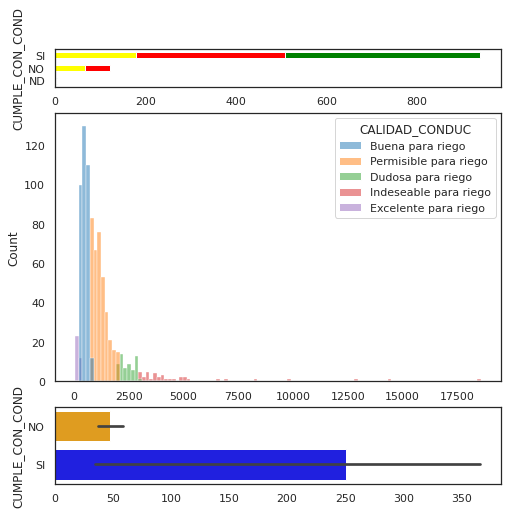

+----+-----------------------+----------+---------+--------+----------+-------+
|    | calidad               | cumple   |   count |    min |     mean |   max |
|----+-----------------------+----------+---------+--------+----------+-------|
|  0 | Excelente para riego  | SI       |      35 |   50.4 |  187.52  |   245 |
|  1 | Buena para riego      | SI       |     352 |  252   |  491.585 |   749 |
|  2 | Permisible para riego | SI       |     366 |  751   | 1195.45  |  1998 |
|  3 | Dudosa para riego     | NO       |      59 | 2004   | 2444.38  |  2957 |
|  4 | Indeseable para riego | NO       |      37 | 3045   | 5207.34  | 18577 |
+----+-----------------------+----------+---------+--------+----------+-------+


In [ ]:
analizar_variable({
    'column': 'CUMPLE_CON_COND',
    'dict_key': 'CUMPLE_CON_COND',
    'type': 'classification',
    'classification_dict': {'value': 'CONDUCT_mS/cm', 'class': 'CALIDAD_CONDUC'}
})

La anterior relación sugiere una relación numérica para la couductividad donde ⪆ 1998 es indeseable y no cumple con la calidad. Nada que incumpla se traslada a verde en el semáforo; por lo que concluimos que deseamos niveles de conductividad ⪅ a 1998, idealmente ⪅ 245 para excelencia en el riego. En concreto esperamos conductividad entre ⪆ 50 y ⪅ a 1998 y en general tenemos más cuerpos con agua permisible para riesgo que de otra clase (⪆ 751 y ⪅ 1998) con 366.

### Cadmio


    -----------------------------------------
    Variable: CD_TOT_mg/L
    -----------------------------------------
    Descripcion: Valor de Cadmio Total, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 854
    NaN: ['<0.003']
    


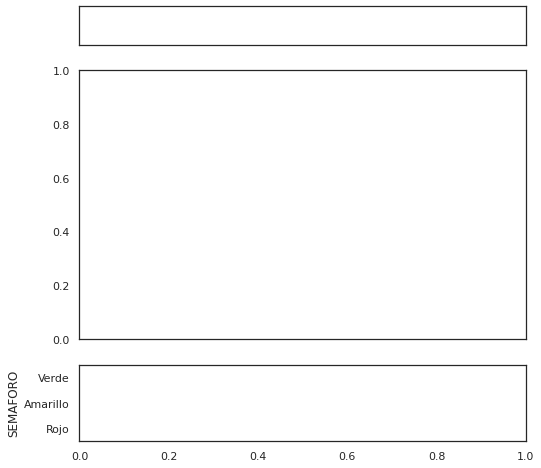

+-------------+---------+--------+-------+-------+-------+-------+-------+-------+
|             |   count |   mean |   std |   min |   25% |   50% |   75% |   max |
|-------------+---------+--------+-------+-------+-------+-------+-------+-------|
| CD_TOT_mg/L |       0 |    nan |   nan |   nan |   nan |   nan |   nan |   nan |
| Verde       |       0 |    nan |   nan |   nan |   nan |   nan |   nan |   nan |
| Amarillo    |       0 |    nan |   nan |   nan |   nan |   nan |   nan |   nan |
| Rojo        |       0 |    nan |   nan |   nan |   nan |   nan |   nan |   nan |
+-------------+---------+--------+-------+-------+-------+-------+-------+-------+


In [ ]:
analizar_variable({
    'column': 'CD_TOT_mg/L',
    'dict_key': 'CD_TOT_mg/L',
    'type': 'pseudonumber',
})

Considerando los no nulos, No se encontraron medidas de Cadmio, todos está clasificados como <0.003, valores superiores a esto quizás sugieran grados de contaminación en incumplimiento de la variable, considerando la toxicidad de este metal.


    -----------------------------------------
    Variable: CUMPLE_CON_CD
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente, para el Indicador Cadmio Total
    Tipo: classification
    Nulos: 0
    
    


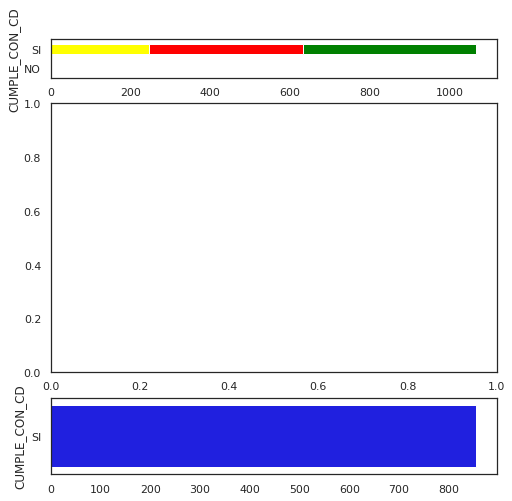

+----+---------------------+----------+---------+-------+--------+-------+
|    | calidad             | cumple   |   count |   min |   mean |   max |
|----+---------------------+----------+---------+-------+--------+-------|
|  0 | Potable - Excelente | SI       |     854 |     0 |      0 |     0 |
+----+---------------------+----------+---------+-------+--------+-------+


In [ ]:
analizar_variable({
    'column': 'CUMPLE_CON_CD',
    'dict_key': 'CUMPLE_CON_CD',
    'type': 'classification',
    'classification_dict': {'value': 'CD_TOT_mg/L', 'class': 'CALIDAD_CD'}
})

No encontramos presencia de CADMIO. Esas deben ser buenas noticias!

### Cromo


    -----------------------------------------
    Variable: CR_TOT_mg/L
    -----------------------------------------
    Descripcion: Valor de Cromo Total, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 689
    NaN: ['<0.005']
    


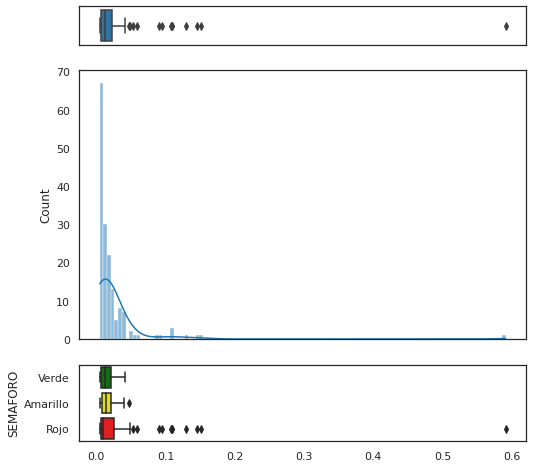

+-------------+---------+-----------+-----------+-------+-----------+----------+-----------+---------+
|             |   count |      mean |       std |   min |       25% |      50% |       75% |     max |
|-------------+---------+-----------+-----------+-------+-----------+----------+-----------+---------|
| CR_TOT_mg/L |     165 | 0.0240813 | 0.0509332 | 0.005 | 0.0074    | 0.01236  | 0.02201   | 0.591   |
| Verde       |      68 | 0.0162743 | 0.0107556 | 0.005 | 0.0074075 | 0.01299  | 0.0217725 | 0.042   |
| Amarillo    |      32 | 0.0174234 | 0.0116056 | 0.005 | 0.008925  | 0.013745 | 0.02195   | 0.04792 |
| Rojo        |      65 | 0.0355265 | 0.0790019 | 0.005 | 0.0071    | 0.0099   | 0.02508   | 0.591   |
+-------------+---------+-----------+-----------+-------+-----------+----------+-----------+---------+


In [ ]:
analizar_variable({
    'column': 'CR_TOT_mg/L',
    'dict_key': 'CR_TOT_mg/L',
    'type': 'pseudonumber',
})

Considerando los no nulos, observamos valores entre 0.05 y 0.591 en cromo, con una media de 0.02 y una desviación de 0.05; el semáforo está relativamente distribuido entre las mediciones; aunque los outliers señalan que altos niveles corresponden a un color rojo. Encontramos 689 nulos clasificados como <0.005 lo que los ubicaría en los valores míinimos y probablemente verdes con respecto al semáforo.


    -----------------------------------------
    Variable: CUMPLE_CON_CR
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente, para el Indicador Cromo Total
    Tipo: classification
    Nulos: 0
    
    


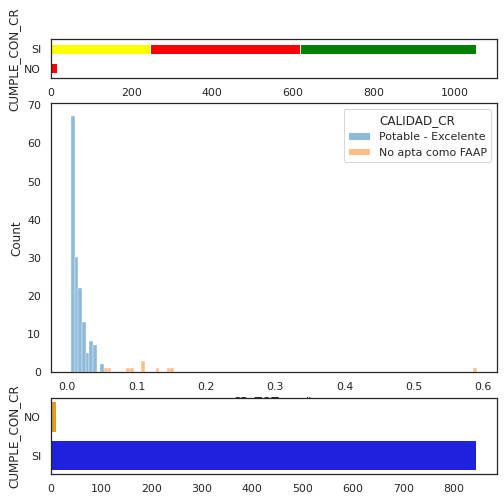

+----+---------------------+----------+---------+--------+-----------+---------+
|    | calidad             | cumple   |   count |    min |      mean |     max |
|----+---------------------+----------+---------+--------+-----------+---------|
|  0 | Potable - Excelente | SI       |     843 | 0      | 0.0027658 | 0.04821 |
|  1 | No apta como FAAP   | NO       |      11 | 0.0533 | 0.149259  | 0.591   |
+----+---------------------+----------+---------+--------+-----------+---------+


In [ ]:
analizar_variable({
    'column': 'CUMPLE_CON_CR',
    'dict_key': 'CUMPLE_CON_CR',
    'type': 'classification',
    'classification_dict': {'value': 'CR_TOT_mg/L', 'class': 'CALIDAD_CR'}
})

La anterior relación sugiere una relación numérica para el cromo donde ⪆ 0.048 es indeseable y no cumple con la calidad. Todo lo que incumple se traslada a rojo en el semáforo; por lo que concluimos que deseamos niveles de cromo ⪅ a 0.048. En general tenemos más cuerpos con agua potble (⪆ 0 y ⪅ 0.048) con 843.

### Dureza


    -----------------------------------------
    Variable: DUR_mg/L
    -----------------------------------------
    Descripcion: Valor de Dureza Total, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 18
    NaN: ['<20']
    


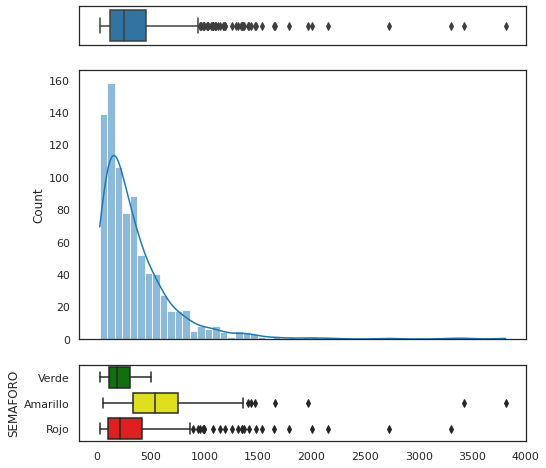

+----------+---------+---------+---------+---------+---------+---------+---------+---------+
|          |   count |    mean |     std |     min |     25% |     50% |     75% |     max |
|----------+---------+---------+---------+---------+---------+---------+---------+---------|
| DUR_mg/L |     836 | 352.993 | 371.603 | 23.68   | 123.306 | 245.662 | 456.016 | 3810.69 |
| Verde    |     334 | 212.187 | 122.773 | 23.68   | 114.56  | 185.526 | 306.576 |  498    |
| Amarillo |     197 | 601.297 | 455.479 | 51      | 338     | 542.958 | 757.86  | 3810.69 |
| Rojo     |     305 | 346.806 | 408.957 | 24.8725 | 101.592 | 210     | 415.785 | 3302.4  |
+----------+---------+---------+---------+---------+---------+---------+---------+---------+


In [ ]:
analizar_variable({
    'column': 'DUR_mg/L',
    'dict_key': 'DUR_mg/L',
    'type': 'pseudonumber',
})

Considerando los no nulos, observamos valores entre 23.68 y 3810.69 en dureza, con una media de 353 y una desviación de 372; altos valores sugieren peores colores en el semáforo. Encontramos 18 nulos clasificados como <20 lo que los ubicaría en los valores míinimos y probablemente verdes con respecto al semáforo.


    -----------------------------------------
    Variable: CUMPLE_CON_DUR
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Suave, Potable - Moderadamente suave, o Potable - Dura, para el Indicador Dureza Total
    Tipo: classification
    Nulos: 0
    
    


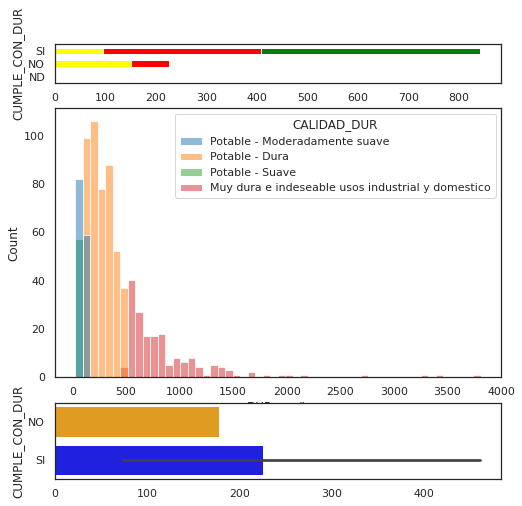

+----+---------------------------------------------------+----------+---------+---------+----------+----------+
|    | calidad                                           | cumple   |   count |     min |     mean |      max |
|----+---------------------------------------------------+----------+---------+---------+----------+----------|
|  0 | Potable - Suave                                   | SI       |      74 |   0     |  34.0873 |   59.838 |
|  1 | Potable - Moderadamente suave                     | SI       |     141 |  60.576 |  90.7422 |  120     |
|  2 | Potable - Dura                                    | SI       |     460 | 120.39  | 269.553  |  498     |
|  3 | Muy dura e indeseable usos industrial y domestico | NO       |     178 | 501.29  | 875.226  | 3810.69  |
+----+---------------------------------------------------+----------+---------+---------+----------+----------+


In [ ]:
analizar_variable({
    'column': 'CUMPLE_CON_DUR',
    'dict_key': 'CUMPLE_CON_DUR',
    'type': 'classification',
    'classification_dict': {'value': 'DUR_mg/L', 'class': 'CALIDAD_DUR'}
})

La anterior relación sugiere una relación numérica para la dureza donde ⪆ 498 es indeseable y no cumple con la calidad. Nada que incumpla se traslada a verde en el semáforo; por lo que concluimos que deseamos niveles de dureza ⪅ a 498, donde es potable. En concreto esperamos una dureza entre ⪆ 0 y ⪅ a 498 y en general tenemos más cuerpos con agua potable dura que de otra clase (⪆ 120 y ⪅ 498) con 460.

### Fluoruros


    -----------------------------------------
    Variable: FLUORUROS_mg/L
    -----------------------------------------
    Descripcion: Valor de Fluoruros Totales (F-), en miligramos por litro
    Tipo: pseudonumber
    Nulos: 123
    NaN: ['<0.2']
    


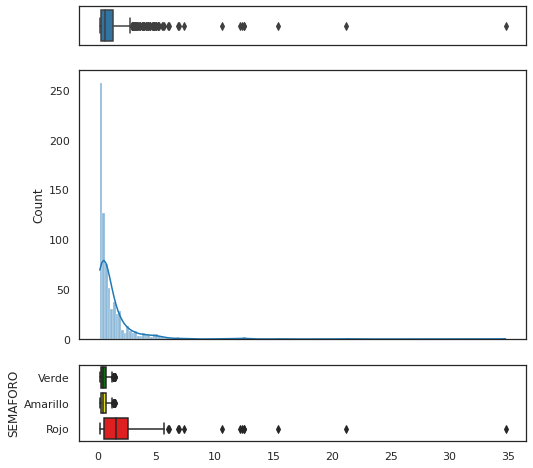

+----------------+---------+----------+----------+--------+----------+---------+---------+---------+
|                |   count |     mean |      std |    min |      25% |     50% |     75% |     max |
|----------------+---------+----------+----------+--------+----------+---------+---------+---------|
| FLUORUROS_mg/L |     731 | 1.23718  | 2.12993  | 0.2008 | 0.34685  | 0.6076  | 1.37045 | 34.8033 |
| Verde          |     277 | 0.560361 | 0.33344  | 0.2035 | 0.299    | 0.448   | 0.7108  |  1.4964 |
| Amarillo       |     154 | 0.544848 | 0.324675 | 0.2008 | 0.306375 | 0.44665 | 0.70035 |  1.4876 |
| Rojo           |     300 | 2.2175   | 3.04695  | 0.2054 | 0.568575 | 1.59755 | 2.6484  | 34.8033 |
+----------------+---------+----------+----------+--------+----------+---------+---------+---------+


In [ ]:
analizar_variable({
    'column': 'FLUORUROS_mg/L',
    'dict_key': 'FLUORUROS_mg/L',
    'type': 'pseudonumber',
})

Considerando los no nulos, observamos valores entre 0.20 y 34.80 en fluoruros, con una media de 1.27 y una desviación de 2.12; se observa una relación a semáforos en rojo cuando observamos mayores niveles. Encontramos 123 nulos clasificados como <0.02 lo que los ubicaría en los valores míinimos y probablemente verdes con respecto al semáforo.


    -----------------------------------------
    Variable: CUMPLE_CON_FLUO
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Baja, Media, o Potable - Optima, para el Indicador Fluoruros Totales
    Tipo: classification
    Nulos: 0
    
    


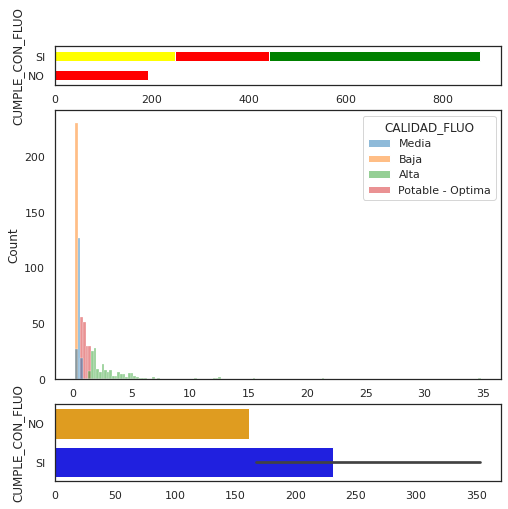

+----+------------------+----------+---------+--------+----------+---------+
|    | calidad          | cumple   |   count |    min |     mean |     max |
|----+------------------+----------+---------+--------+----------+---------|
|  0 | Baja             | SI       |     353 | 0      | 0.18991  |  0.3991 |
|  1 | Media            | SI       |     173 | 0.4    | 0.522758 |  0.699  |
|  2 | Potable - Optima | SI       |     167 | 0.7001 | 1.03268  |  1.4964 |
|  3 | Alta             | NO       |     161 | 1.5103 | 3.56797  | 34.8033 |
+----+------------------+----------+---------+--------+----------+---------+


In [ ]:
analizar_variable({
    'column': 'CUMPLE_CON_FLUO',
    'dict_key': 'CUMPLE_CON_FLUO',
    'type': 'classification',
    'classification_dict': {'value': 'FLUORUROS_mg/L', 'class': 'CALIDAD_FLUO'}
})

La anterior relación sugiere una relación numérica para los fluoruros donde ⪆ 1.5 es indeseable y no cumple con la calidad. Todo lo que incumple se traslada a rojo en el semáforo; por lo que concluimos que deseamos niveles de flurorur ⪅ a 1.5, idealmente ⪆ 0.70 ⪅ 1.50 para ser óptima. En concreto esperamos presencia de flururos ⪅ a 1.50 y en general tenemos más cuerpos con bajo flururo que de otra clase (⪆ 0 y ⪅ 0.40) con 353.

### Hierro


    -----------------------------------------
    Variable: FE_TOT_mg/L
    -----------------------------------------
    Descripcion: Valor de Hierro Total, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 323
    NaN: ['<0.025']
    


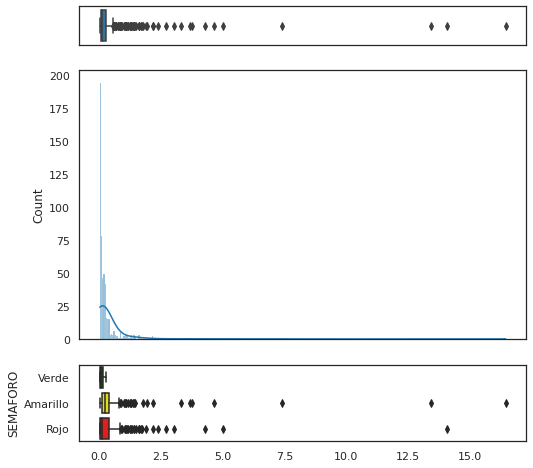

+-------------+---------+----------+-----------+---------+-----------+---------+----------+---------+
|             |   count |     mean |       std |     min |       25% |     50% |      75% |     max |
|-------------+---------+----------+-----------+---------+-----------+---------+----------+---------|
| FE_TOT_mg/L |     531 | 0.394992 | 1.25898   | 0.0253  | 0.05605   | 0.1165  | 0.26053  | 16.4371 |
| Verde       |     177 | 0.106048 | 0.0758464 | 0.0253  | 0.0465    | 0.07547 | 0.1661   |  0.2901 |
| Amarillo    |     166 | 0.632596 | 1.80782   | 0.02701 | 0.0983775 | 0.2288  | 0.39305  | 16.4371 |
| Rojo        |     188 | 0.45723  | 1.21251   | 0.0253  | 0.052475  | 0.10047 | 0.385027 | 14.06   |
+-------------+---------+----------+-----------+---------+-----------+---------+----------+---------+


In [ ]:
analizar_variable({
    'column': 'FE_TOT_mg/L',
    'dict_key': 'FE_TOT_mg/L',
    'type': 'pseudonumber',
})

Considerando los no nulos, observamos valores entre 0.25 y 16.44 en hierro, con una media de 0.40 y una desviación de 1.26; No es fácil observar una relación en altos valores a semáforos rojos, aunque en general para semáforo verde la medida esta baja. Encontramos 323 nulos clasificados como <0.025 lo que los ubicaría en los valores míinimos y probablemente verdes con respecto al semáforo.


    -----------------------------------------
    Variable: CUMPLE_CON_FE
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente, para el Indicador Hierro Total
    Tipo: classification
    Nulos: 0
    
    


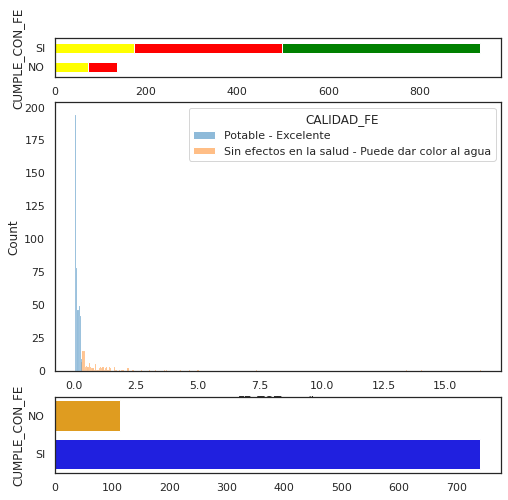

+----+---------------------------------------------------+----------+---------+--------+-----------+---------+
|    | calidad                                           | cumple   |   count |    min |      mean |     max |
|----+---------------------------------------------------+----------+---------+--------+-----------+---------|
|  0 | Potable - Excelente                               | SI       |     741 | 0      | 0.0625434 |  0.2983 |
|  1 | Sin efectos en la salud - Puede dar color al agua | NO       |     113 | 0.3001 | 1.44598   | 16.4371 |
+----+---------------------------------------------------+----------+---------+--------+-----------+---------+


In [ ]:
analizar_variable({
    'column': 'CUMPLE_CON_FE',
    'dict_key': 'CUMPLE_CON_FE',
    'type': 'classification',
    'classification_dict': {'value': 'FE_TOT_mg/L', 'class': 'CALIDAD_FE'}
})

La anterior relación sugiere una relación numérica para el hierro donde ⪆ 0.29 es indeseable y no cumple con la calidad. Nada que incumple se traslada a verde en el semáforo; por lo que concluimos que deseamos niveles de hierro ⪅ a 0.29. En general tenemos más cuerpos con agua potable excelente que de otra clase (⪆ 0 y ⪅ 0.29) con 741.

### Manganeso


    -----------------------------------------
    Variable: MN_TOT_mg/L
    -----------------------------------------
    Descripcion: Valor de Manganeso Total, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 436
    NaN: ['<0.0015']
    


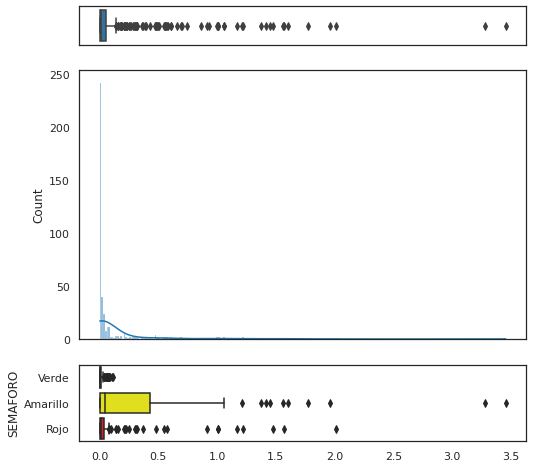

+-------------+---------+-----------+----------+--------+----------+----------+----------+--------+
|             |   count |      mean |      std |    min |      25% |      50% |      75% |    max |
|-------------+---------+-----------+----------+--------+----------+----------+----------+--------|
| MN_TOT_mg/L |     418 | 0.144482  | 0.387391 | 0.0015 | 0.003625 | 0.01082  | 0.05813  | 3.4548 |
| Verde       |     131 | 0.0152613 | 0.022728 | 0.0015 | 0.0029   | 0.0056   | 0.01525  | 0.1165 |
| Amarillo    |     129 | 0.322383  | 0.570972 | 0.0015 | 0.0078   | 0.0497   | 0.4308   | 3.4548 |
| Rojo        |     158 | 0.106372  | 0.301629 | 0.0015 | 0.003825 | 0.010965 | 0.034725 | 2.015  |
+-------------+---------+-----------+----------+--------+----------+----------+----------+--------+


In [ ]:
analizar_variable({
    'column': 'MN_TOT_mg/L',
    'dict_key': 'MN_TOT_mg/L',
    'type': 'pseudonumber',
})

Observamos valores entre 0.0015 y 03.4548 en manganeso, con una media de 0.14 y una desviación de 0.38; se observa una clara tendencia al semáforo amarillo cuando la presencia de manganeso es alta. Encontramos 436 nulos clasificados como <0.0015 lo que los ubicaría en los valores míinimos y probablemente verdes con respecto al semáforo.


    -----------------------------------------
    Variable: CUMPLE_CON_MN
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente, para el Indicador Manganeso Total
    Tipo: classification
    Nulos: 0
    
    


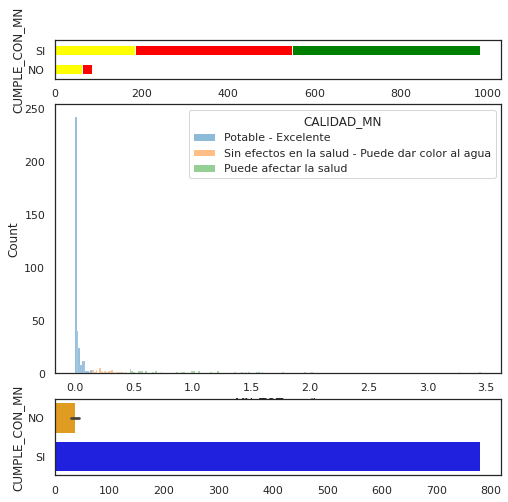

+----+---------------------------------------------------+----------+---------+--------+------------+---------+
|    | calidad                                           | cumple   |   count |    min |       mean |     max |
|----+---------------------------------------------------+----------+---------+--------+------------+---------|
|  0 | Potable - Excelente                               | SI       |     780 | 0      | 0.00780556 | 0.14319 |
|  1 | Sin efectos en la salud - Puede dar color al agua | NO       |      30 | 0.1564 | 0.256628   | 0.398   |
|  2 | Puede afectar la salud                            | NO       |      44 | 0.4308 | 1.05923    | 3.4548  |
+----+---------------------------------------------------+----------+---------+--------+------------+---------+


In [ ]:
analizar_variable({
    'column': 'CUMPLE_CON_MN',
    'dict_key': 'CUMPLE_CON_MN',
    'type': 'classification',
    'classification_dict': {'value': 'MN_TOT_mg/L', 'class': 'CALIDAD_MN'}
})

La anterior relación sugiere una relación numérica para el manganeso donde ⪆ 0.0.15 es indeseable y no cumple con la calidad. Nada que incumpla se traslada a verde en el semáforo; por lo que concluimos que deseamos niveles de manganeso ⪅ a 0.40, idealmente ⪅ 0.15 para ser excelente. En concreto esperamos presencia de manganeso entre ⪆ 0 y ⪅ a 0.15 y en general tenemos más cuerpos con agua potable excelente que de otra clase (⪆ 0 y ⪅ 0.15) con 780.

### Mercurio


    -----------------------------------------
    Variable: HG_TOT_mg/L
    -----------------------------------------
    Descripcion: Valor de Mercurio Total, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 775
    NaN: ['<0.0005']
    


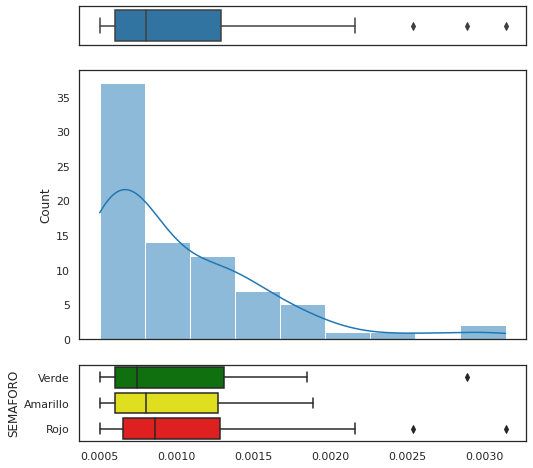

+-------------+---------+-------------+-------------+--------+---------+---------+---------+---------+
|             |   count |        mean |         std |    min |     25% |     50% |     75% |     max |
|-------------+---------+-------------+-------------+--------+---------+---------+---------+---------|
| HG_TOT_mg/L |      79 | 0.00101051  | 0.000556034 | 0.0005 | 0.0006  | 0.0008  | 0.00129 | 0.00314 |
| Verde       |      33 | 0.000982424 | 0.000547631 | 0.0005 | 0.0006  | 0.00074 | 0.00131 | 0.00289 |
| Amarillo    |      21 | 0.000954286 | 0.000434552 | 0.0005 | 0.0006  | 0.0008  | 0.00127 | 0.00189 |
| Rojo        |      25 | 0.0010948   | 0.000660556 | 0.0005 | 0.00065 | 0.00086 | 0.00128 | 0.00314 |
+-------------+---------+-------------+-------------+--------+---------+---------+---------+---------+


In [ ]:
analizar_variable({
    'column': 'HG_TOT_mg/L',
    'dict_key': 'HG_TOT_mg/L',
    'type': 'pseudonumber',
})

Considerando los no nulos, observamos valores entre 0.0005 y 0.003 en mercurio, con una media de 0.001 y una desviación de 0.0005; los valores están relativamente distribuidos entre los semáforos. Encontramos 775 nulos clasificados como <0.0005 lo que los ubicaría en los valores míinimos y probablemente verdes con respecto al semáforo.


    -----------------------------------------
    Variable: CUMPLE_CON_HG
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente, para el Indicador Mercurio Total
    Tipo: classification
    Nulos: 0
    
    


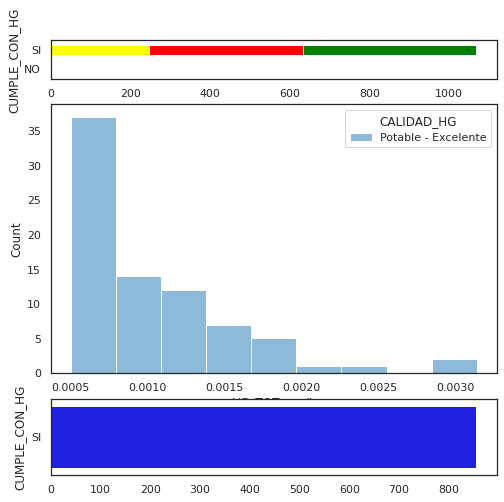

+----+---------------------+----------+---------+-------+-------------+---------+
|    | calidad             | cumple   |   count |   min |        mean |     max |
|----+---------------------+----------+---------+-------+-------------+---------|
|  0 | Potable - Excelente | SI       |     854 |     0 | 9.34778e-05 | 0.00314 |
+----+---------------------+----------+---------+-------+-------------+---------+


In [ ]:
analizar_variable({
    'column': 'CUMPLE_CON_HG',
    'dict_key': 'CUMPLE_CON_HG',
    'type': 'classification',
    'classification_dict': {'value': 'HG_TOT_mg/L', 'class': 'CALIDAD_HG'}
})

No encontramos niveles de mercurio inaceptable. Esas deben ser buenas noticias!

### Nitrógeno de Nitratos


    -----------------------------------------
    Variable: N_NO3_mg/L
    -----------------------------------------
    Descripcion: Valor de Nitrogeno de Nitratos, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 60
    NaN: ['<0.02']
    


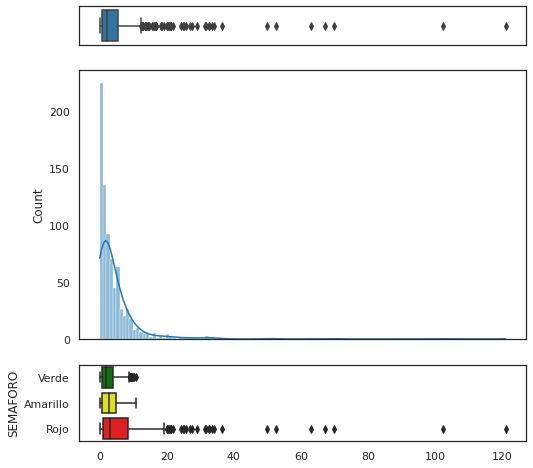

+------------+---------+---------+----------+----------+----------+---------+---------+----------+
|            |   count |    mean |      std |      min |      25% |     50% |     75% |      max |
|------------+---------+---------+----------+----------+----------+---------+---------+----------|
| N_NO3_mg/L |     794 | 4.66861 |  8.74979 | 0.0208   | 0.829748 | 2.23125 | 5.4188  | 121.008  |
| Verde      |     320 | 2.77886 |  2.65995 | 0.0208   | 0.704455 | 1.93486 | 3.96287 |  10.7466 |
| Amarillo   |     170 | 3.10038 |  2.65744 | 0.022059 | 0.752898 | 2.63324 | 4.89812 |  10.8918 |
| Rojo       |     304 | 7.5348  | 13.2509  | 0.021    | 1.08929  | 3.09737 | 8.38588 | 121.008  |
+------------+---------+---------+----------+----------+----------+---------+---------+----------+


In [ ]:
analizar_variable({
    'column': 'N_NO3_mg/L',
    'dict_key': 'N_NO3_mg/L',
    'type': 'pseudonumber',
})

Considerando los no nulos, observamos valores entre 0.02 y 121 en nitógeno de nitratos, con una media de 4.67 y una desviación de 8.75; se observa una tendencia al semáforo rojo cuando la presencia de nitrógeno de nitrato es alta. Encontramos 60 nulos clasificados como <0.02 lo que los ubicaría en los valores míinimos y probablemente verdes con respecto al semáforo.


    -----------------------------------------
    Variable: CUMPLE_CON_NO3
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente o Potable - Buena calidad, para el Indicador Nitrogeno de Nitratos
    Tipo: classification
    Nulos: 0
    
    


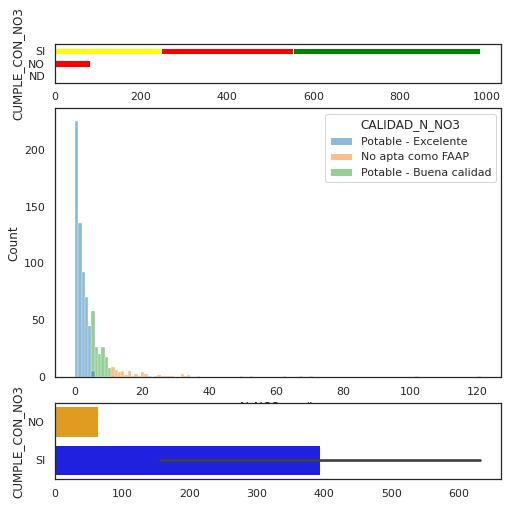

+----+-------------------------+----------+---------+---------+----------+-----------+
|    | calidad                 | cumple   |   count |     min |     mean |       max |
|----+-------------------------+----------+---------+---------+----------+-----------|
|  0 | Potable - Excelente     | SI       |     631 |  0      |  1.56096 |   4.99221 |
|  1 | Potable - Buena calidad | SI       |     157 |  5.022  |  7.0744  |  10.8918  |
|  2 | No apta como FAAP       | NO       |      65 | 11.0041 | 24.7881  | 121.008   |
+----+-------------------------+----------+---------+---------+----------+-----------+


In [ ]:
analizar_variable({
    'column': 'CUMPLE_CON_NO3',
    'dict_key': 'CUMPLE_CON_NO3',
    'type': 'classification',
    'classification_dict': {'value': 'N_NO3_mg/L', 'class': 'CALIDAD_N_NO3'}
})

La anterior relación sugiere una relación numérica para el nitrógeno de nitrato donde ⪆ 11 es indeseable y no cumple con la calidad. Todo lo que incumple se traslada a rojo en el semáforo; por lo que concluimos que deseamos niveles de nitrógeno de nitrato ⪅ a 11, idealmente ⪅ 5 para ser excelente. En concreto esperamos presencia de alacalinidad entre ⪆ 0 y ⪅ a 5 y en general tenemos más cuerpos con agua excelente que de otra clase (⪆ 0 y ⪅ 5) con 631.

### Plomo


    -----------------------------------------
    Variable: PB_TOT_mg/L
    -----------------------------------------
    Descripcion: Valor de Plomo Total, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 830
    NaN: ['<0.005']
    


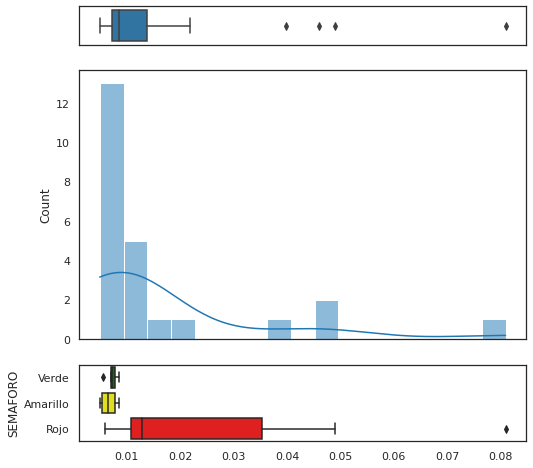

+-------------+---------+------------+------------+---------+-----------+----------+-----------+---------+
|             |   count |       mean |        std |     min |       25% |      50% |       75% |     max |
|-------------+---------+------------+------------+---------+-----------+----------+-----------+---------|
| PB_TOT_mg/L |      24 | 0.0168142  | 0.0185861  | 0.005   | 0.0072775 | 0.008595 | 0.013925  | 0.0809  |
| Verde       |       6 | 0.00733667 | 0.00104422 | 0.00556 | 0.0071075 | 0.007355 | 0.00794   | 0.00859 |
| Amarillo    |       4 | 0.006715   | 0.00170842 | 0.005   | 0.0054275 | 0.00663  | 0.0079175 | 0.0086  |
| Rojo        |      14 | 0.0237614  | 0.0220285  | 0.00596 | 0.010855  | 0.012875 | 0.0354    | 0.0809  |
+-------------+---------+------------+------------+---------+-----------+----------+-----------+---------+


In [ ]:
analizar_variable({
    'column': 'PB_TOT_mg/L',
    'dict_key': 'PB_TOT_mg/L',
    'type': 'pseudonumber',
})

Considerando los no nulos, observamos valores entre 0.005 y 0.08 en el plomo, con una media de 0.017 y una desviación de 0.018; se observa una clara tendencia al semáforo rojo cuando la presencia de plomo es alta. Encontramos 830 nulos clasificados como <0.005 lo que los ubicaría en los valores míinimos y probablemente verdes con respecto al semáforo.


    -----------------------------------------
    Variable: CUMPLE_CON_PB
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente, para el Indicador Plomo Total
    Tipo: classification
    Nulos: 0
    
    


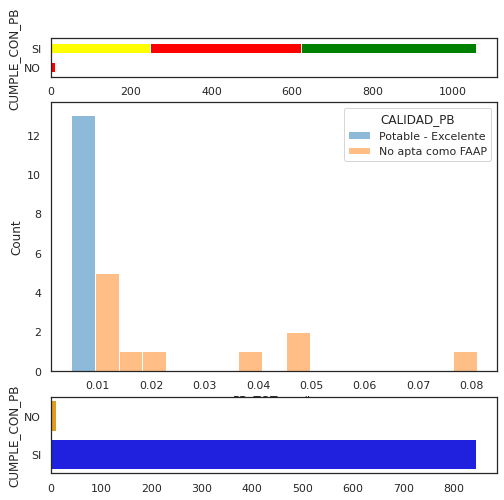

+----+---------------------+----------+---------+---------+-------------+--------+
|    | calidad             | cumple   |   count |     min |        mean |    max |
|----+---------------------+----------+---------+---------+-------------+--------|
|  0 | Potable - Excelente | SI       |     843 | 0       | 0.000108387 | 0.0086 |
|  1 | No apta como FAAP   | NO       |      11 | 0.01075 | 0.0283791   | 0.0809 |
+----+---------------------+----------+---------+---------+-------------+--------+


In [ ]:
analizar_variable({
    'column': 'CUMPLE_CON_PB',
    'dict_key': 'CUMPLE_CON_PB',
    'type': 'classification',
    'classification_dict': {'value': 'PB_TOT_mg/L', 'class': 'CALIDAD_PB'}
})

La anterior relación sugiere una relación numérica para el plomo donde ⪆ 0.01 es indeseable y no cumple con la calidad. Todo lo que incumple se traslada a rojo en el semáforo; por lo que concluimos que deseamos niveles de plomo ⪅ a 0.01. En general tenemos más cuerpos con agua potable que de otra clase (⪆ 0 y ⪅ 0.01) con 843.

### Sólidos Disueltos


    -----------------------------------------
    Variable: SDT_M_mg/L
    -----------------------------------------
    Descripcion: Valor de Solidos Disueltos Totales-Medidos, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 2
    NaN: ['<25']
    


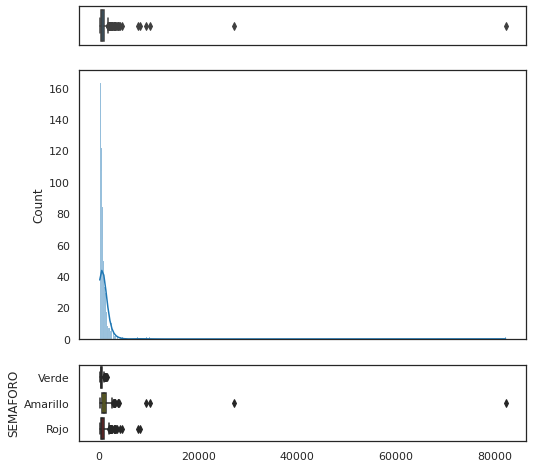

+------------+---------+----------+----------+-------+--------+-------+---------+---------+
|            |   count |     mean |      std |   min |    25% |   50% |     75% |     max |
|------------+---------+----------+----------+-------+--------+-------+---------+---------|
| SDT_M_mg/L |     852 |  907.401 | 3049.85  | 101.2 | 334.7  | 540   |  905.3  | 82170   |
| Verde      |     336 |  452.298 |  229.353 | 101.2 | 280.45 | 396.5 |  586.05 |  1614   |
| Amarillo   |     198 | 1721.25  | 6141.83  | 152   | 613.15 | 909.5 | 1445.95 | 82170   |
| Rojo       |     318 |  881.528 |  915.788 | 139.4 | 351.85 | 579   | 1015.35 |  8230.4 |
+------------+---------+----------+----------+-------+--------+-------+---------+---------+


In [ ]:
analizar_variable({
    'column': 'SDT_M_mg/L',
    'dict_key': 'SDT_M_mg/L',
    'type': 'pseudonumber',
})

Considerando los no nulos, observamos valores entre 101.2 y 82170 en sólidos disueltos, con una media de 0.907.40 y una desviación de 3049.5; los datos están relativamente balanceados entre los colores del semáforo. Encontramos 2 nulos clasificados como <25 lo que los ubicaría en los valores míinimos y probablemente verdes con respecto al semáforo.


    -----------------------------------------
    Variable: CUMPLE_CON_SDT_ra
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Excelente para riego, Cultivos sensibles o Cultivos con manejo especial, para el Indicador SDT (Riego agr­cola)
    Tipo: classification
    Nulos: 0
    
    


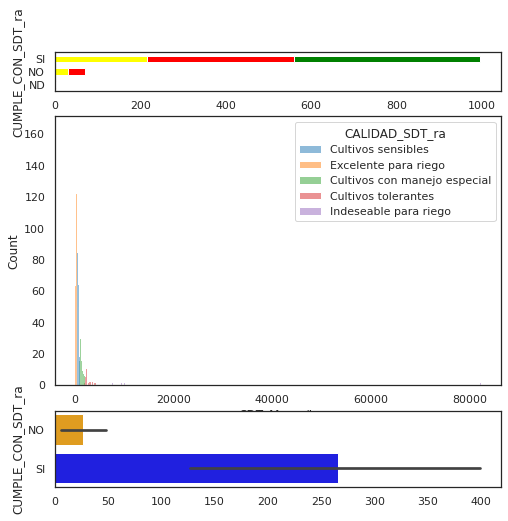

+----+------------------------------+----------+---------+--------+-----------+---------+
|    | calidad                      | cumple   |   count |    min |      mean |     max |
|----+------------------------------+----------+---------+--------+-----------+---------|
|  0 | Excelente para riego         | SI       |     399 |    0   |   326.639 |   500   |
|  1 | Cultivos sensibles           | SI       |     273 |  500.2 |   713.673 |   999.8 |
|  2 | Cultivos con manejo especial | SI       |     127 | 1011.4 |  1369.27  |  1995   |
|  3 | Cultivos tolerantes          | NO       |      48 | 2025   |  2687.18  |  4676   |
|  4 | Indeseable para riego        | NO       |       6 | 7746   | 24177     | 82170   |
+----+------------------------------+----------+---------+--------+-----------+---------+


In [ ]:
analizar_variable({
    'column': 'CUMPLE_CON_SDT_ra',
    'dict_key': 'CUMPLE_CON_SDT_ra',
    'type': 'classification',
    'classification_dict': {'value': 'SDT_M_mg/L', 'class': 'CALIDAD_SDT_ra'}
})

La anterior relación sugiere una relación numérica para los sólidos disueltos donde ⪆ 1995 es indeseable y no cumple con la calidad. Nada que incumple se traslada a verde en el semáforo; por lo que concluimos que deseamos niveles de sólidos disueltos ⪅ 1995, idealmente ⪅ 500 para riego. En concreto esperamos presencia de sólidos disueltos entre ⪆ 0 y ⪅ a 500 y en general tenemos más cuerpos con agua excelentes para riesgo que de otra clase (⪆ 0 y ⪅ 500) con 399.


    -----------------------------------------
    Variable: CUMPLE_CON_SDT_salin
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Dulce  o Ligeramente salobres, para el Indicador Solidos Disueltos Totales (Salinizaci½n)
    Tipo: classification
    Nulos: 0
    
    


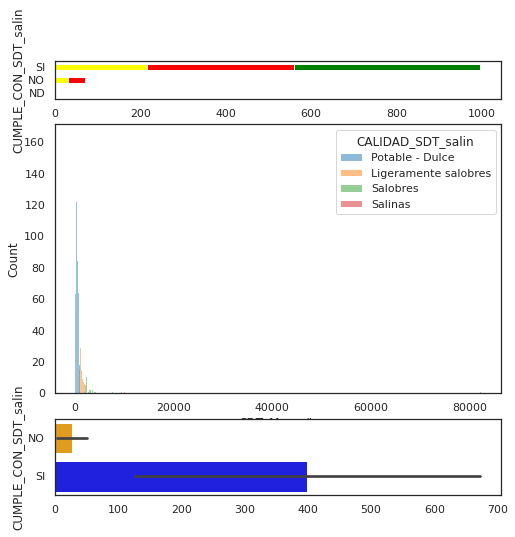

+----+----------------------+----------+---------+---------+-----------+----------+
|    | calidad              | cumple   |   count |     min |      mean |      max |
|----+----------------------+----------+---------+---------+-----------+----------|
|  0 | Potable - Dulce      | SI       |     672 |     0   |   483.872 |   999.8  |
|  1 | Ligeramente salobres | SI       |     127 |  1011.4 |  1369.27  |  1995    |
|  2 | Salobres             | NO       |      51 |  2025   |  3028.72  |  9503.67 |
|  3 | Salinas              | NO       |       3 | 10196   | 39860.6   | 82170    |
+----+----------------------+----------+---------+---------+-----------+----------+


In [ ]:
analizar_variable({
    'column': 'CUMPLE_CON_SDT_salin',
    'dict_key': 'CUMPLE_CON_SDT_salin',
    'type': 'classification',
    'classification_dict': {'value': 'SDT_M_mg/L', 'class': 'CALIDAD_SDT_salin'}
})

La anterior relación sugiere una relación numérica para los sólidos disueltos ydonde ⪆ 1995 es salobre y no cumple con la calidad. Nada que incumple se traslada a verde en el semáforo; por lo que concluimos que deseamos niveles de sólidos disueltos ⪅ 1995, idealmente ⪅ 1000 para ser potables. En concreto esperamos presencia de sólidos disueltos entre ⪆ 0 y ⪅ a 1000 y en general tenemos más cuerpos con agua dulce potable que de otra clase (⪆ 0 y ⪅ 1000) con 672.

### Contaminantes vs. semaforo

Durante los análisis anteriores hemos encontrado bastantes coincidencias entre el color del semáforo y las variables de contaminación. Un ejemplo es que en general, parece no existir color verde para cuando algun contaminante no cumple con sus medidas binarias (cumple o no). Validamos esto:

In [ ]:
(
    X_train
    .join(y)
    .groupby(['CONTAMINANTES', 'SEMAFORO'], dropna=False)
    .size()
    .reset_index(name='counts')
    .sort_values(by=['SEMAFORO', 'CONTAMINANTES'])
)

,CONTAMINANTES,SEMAFORO,counts
0,"ALC,",Amarillo,9
4,"ALC,CONDUC,",Amarillo,1
6,"ALC,CONDUC,DT,",Amarillo,2
10,"ALC,CONDUC,SDT_ra,SDT_salin,DT,MN,FE,",Amarillo,1
14,"ALC,DT,",Amarillo,5
...,...,...,...
103,"PB,FE,",Rojo,3
104,"PB,MN,FE,",Rojo,1
106,"SDT_ra,SDT_salin,DT,CR,",Rojo,1
110,"SDT_ra,SDT_salin,DT,NO3,",Rojo,1


Aquí observamos que la variable contaminante sugiere que no existe un color verde para cuando esta tiene valor y que ciertos contaminantes están al parecer ligados al color. Veamos si podemos extrar una relación de esto. Para ello, consideremos que ya tenemos las variables binarias de CUMPLE o NO.

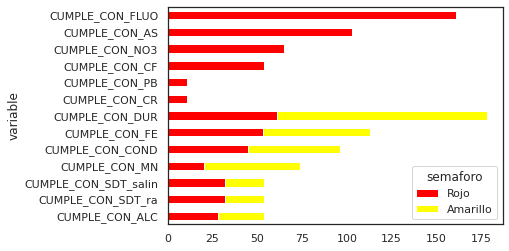

In [ ]:
# Formemos la lista de contaminantes y semaforo:
contaminantes_y_semaforo = [
    'CUMPLE_CON_ALC',
    'CUMPLE_CON_AS',
    'CUMPLE_CON_CD',
    'CUMPLE_CON_CF',
    'CUMPLE_CON_COND',
    'CUMPLE_CON_CR',
    'CUMPLE_CON_DUR',
    'CUMPLE_CON_FLUO',
    'CUMPLE_CON_FE',
    'CUMPLE_CON_MN',
    'CUMPLE_CON_HG',
    'CUMPLE_CON_NO3',
    'CUMPLE_CON_PB',
    'CUMPLE_CON_SDT_ra',
    'CUMPLE_CON_SDT_salin',
    'SEMAFORO',
]



# Creemos un dataframe de estos datos:
intdf = (
    X_train
    .join(y)
    .loc[: , contaminantes_y_semaforo]
)

# Creemos un dataframe para almacenar:
parent_df = pd.DataFrame({
    'variable': pd.Series(dtype='str'),
    'cumple': pd.Series(dtype='str'),
    'semaforo': pd.Series(dtype='str'),
    'cnt': pd.Series(dtype='int')
})


# Tomemos cada variable y veamos su clasificación cuando da NO
for contaminante in contaminantes_y_semaforo[:-1]:

  append_df = intdf[(intdf[[contaminante]] == 'NO').any(axis=1)][[contaminante, 'SEMAFORO']].value_counts().reset_index(name='cnt')
  append_df['VARIABLE'] = contaminante
  append_df = append_df[['VARIABLE', contaminante, 'SEMAFORO', 'cnt']]
  append_df.columns = ['variable', 'cumple', 'semaforo', 'cnt']
  parent_df = parent_df.append(append_df)

# Ordenemo en un pivote:
parent_df = ( 
    parent_df
    .pivot(index='variable', columns='semaforo', values='cnt')
    .fillna(0)
)

# Creemos el total
parent_df['total'] = parent_df['Rojo'] + parent_df['Amarillo']

# Veamos cuantas clases tiene (Rojo y Amarillo):
parent_df['clases'] = np.sign(parent_df['Rojo']) +np.sign(parent_df['Amarillo'])

# Ordenemos los valores:
parent_df = parent_df.sort_values(['clases', 'total'], ascending=[False, True])

# Grafiquemos:
parent_df.loc[:, ['Rojo', 'Amarillo']].plot(kind='barh', stacked='true', color={ 'Verde': 'green', 'Rojo': 'red', 'Amarillo': 'yellow', 'ND': 'gray', 'total': 'black'})
plt.show()

Esto sugiere que existen cierto tipo de contaminantes que en su incumplimiento llevan a semáforo rojo, a saber:
* Fluoruros
* Arsénico
* Nitrógeno de nitratos
* Coliformes Fecales
* Plomo
* Cromo

Mientras que los otros por si mismos no llevan a la variable a este nivel.

### Correlación entre contaminantes

Ahora veamos si existe relación entre las variables numéricas; como observamos tenemos varias pseudo-numéricas sólo por que están por debajo de los niveles esperados; lo que haremos con ellas es una imputación de los valores mínimos y así ver todos los contaminantes y ver si entre ellos se relacionan.

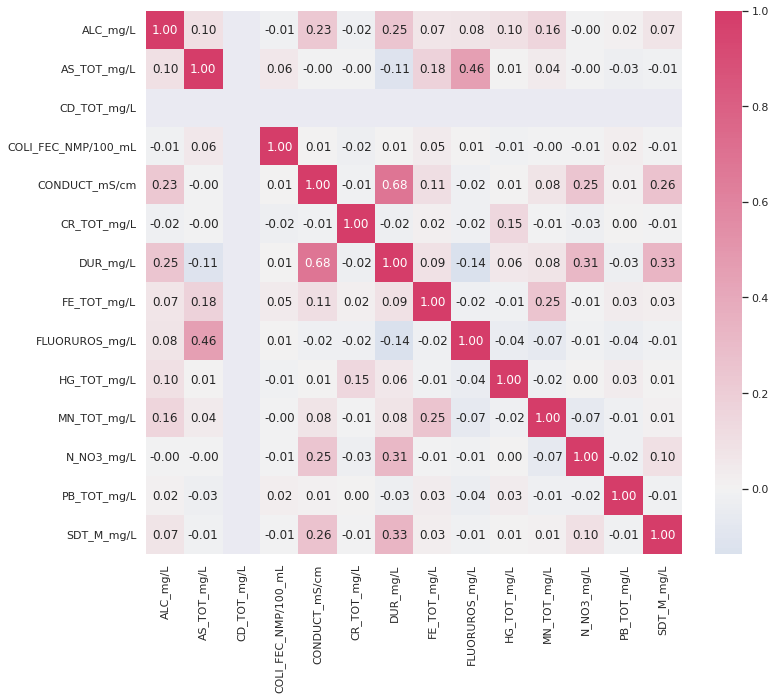

In [ ]:
# Comencemos por generar un conjunto con todas las variables numéricas y pseudonuméricas; usaremos un coerce para luego imputar datos
variables_numericas = ['ALC_mg/L', 'AS_TOT_mg/L', 'CD_TOT_mg/L', 'COLI_FEC_NMP/100_mL', 'CONDUCT_mS/cm', 'CR_TOT_mg/L', 'DUR_mg/L', 'FE_TOT_mg/L', 'FLUORUROS_mg/L', 'HG_TOT_mg/L', 'MN_TOT_mg/L', 'N_NO3_mg/L', 'PB_TOT_mg/L', 'SDT_M_mg/L']
df_numericos = X_train[variables_numericas].apply(pd.to_numeric, errors='coerce')

# Definamos un simple imputer para valores mínimos
#df_numericos
df_numericos = df_numericos.fillna(df_numericos.min())

# Creemos la matriz de correlación
corr_matrix = df_numericos.corr()

# pongamos un canvas
sns.set(rc = {'figure.figsize':(12,10)})

# Heamap of correlation
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    center=0,
    cmap=sns.diverging_palette(255, 0, as_cmap=True)
)

Encontramos alta correlación entre Arsénico y Fluoruros, en la Conductividad y la Dureza y esta también con salinidad y plomo. Esto nos puede ayudar a ver contaminantes correlacionados, probablemente por fuentes de contaminación comunes.

# Pipeline para ML

En este análisis encontramos que el semáforo responde a los contaminantes que no cumplen; a su vez que estos llegan a esta clasificación por su valores numéricos y que además estos parecen muy bien definidos en sus límites, los histogramas de calidad mostraron esto de manera continua y lo mismo las tablas de mínimos y máximos; luego parece que las variables de interés serían los valores numéricos ya que estos por si mismos parecen capaces de predecir si algo cumple en calidad o no y esto a su vez puede ser tomado para generar la calidad final (semáforo).

Lo que proponemos es generar un modelo basado en las medidas de niveles de contaminantes para predecir el semáforo final. Para lidiar con los nulos, antes de hacer simples imputaciones podríamos expander el modelo geográfico a otro algoritmo: K-Nearest-Neighbours, con este cada valor que encuentre un nulo en su observación podría ver una cantidad (n) de cuerpos de agua vecinos y tomar el promedio de su valor. Por ejemplo:

Supongamos que tenemos un neuvo punto en una latitud $lat_i$ y $lon_i$; este a su vez tendrá un conjunto $C_ij$ donde cada valor corresponda a una medición de contaminación; decimos que, si un valor es desconocido, este será el promedio de sus 5 (por decir un número) vecinos más cercanos ya que el análisis geográfico demostro consistencia en el espacio; esto o lo que sugieran nuestros clusters de K-Means.

Esto servirá como nuestro método de imput. Adicionalmente proponemos normalizar las variables numéricas y mover todas las observaciones alfábeticas a los mínimos observados, ya que nuestro análisis mostró que así es como se clasifican las pseudonuméricas, además observamos que los mínimos están en cumplimiento siempre por lo que esto no debería de generar ruido.

De manera general proponemos el siguiente pseudoalgoritmo:

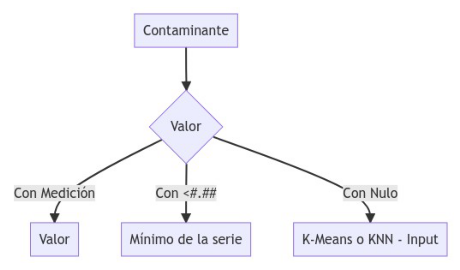

In [ ]:
############################################################################################
# Pseudo algoritmo de imput presentado con mermaid-md:
# basado en: https://github.com/mermaid-js/mermaid/issues/1791
# por: https://github.com/theroyakash
############################################################################################
graph = """
graph TD;
    A[Contaminante]-->C{Valor}
    C-->|Con Medición|F[Valor]
    C-->|Con <#.##|E[Mínimo de la serie]
    C-->|Con Nulo|D[K-Means o KNN - Input]
"""
graphbytes = graph.encode("utf-8")

base64_bytes = base64.b64encode(graphbytes)
base64_string = base64_bytes.decode("ascii")

fig, ax = plt.subplots(figsize=(8,8))
img = Image.open(io.BytesIO(requests.get('https://mermaid.ink/img/' + base64_string).content))
plt.imshow(img)
plt.axis('off')
plt.show()

Este pseudoalgoritmo se elaborará para la segunda entrega y utilizará:

| Variable | Método para nulos | Transformación | Propósito |
| --- | --- | --- | --- |
| Latitud | Drop (si lo demás también es nulo) | - | Ubicar y permitir aplicar KNN o K-Means |
| Longitud | Drop (si lo demás también es nulo) | - | Ubicar y permitir aplicar KNN o K-Means |
| ALC_mg/L	| KNN/K-Means | Z-Scale | Medir grado de contaminación |
| AS_TOT_mg_L	| KNN/K-Means | Z-Scale | Medir grado de contaminación |
| CD_TOT_mg/L	| KNN/K-Means | Z-Scale | Medir grado de contaminación |
| COLI_FEC_NMP/100_mL	| KNN/K-Means | Z-Scale | Medir grado de contaminación |
| CONDUCT_mS/cm	| KNN/K-Means | Z-Scale | Medir grado de contaminación |
| CR_TOT_mg/L	| KNN/K-Means | Z-Scale | Medir grado de contaminación |
| DUR_mg/L	| KNN/K-Means | Z-Scale | Medir grado de contaminación |
| FE_TOT_mg/L	| KNN/K-Means | Z-Scale | Medir grado de contaminación |
| FLUORUROS_mg/L	| KNN/K-Means | Z-Scale | Medir grado de contaminación |
| HG_TOT_mg/L	| KNN/K-Means | Z-Scale | Medir grado de contaminación |
| MN_TOT_mg/L	| KNN/K-Means | Z-Scale | Medir grado de contaminación |
| N_NO3_mg/L	| KNN/K-Means | Z-Scale | Medir grado de contaminación |
| PB_TOT_mg/L	| KNN/K-Means | Z-Scale | Medir grado de contaminación |
| SDT_mg/L	| KNN/K-Means | Z-Scale | Medir grado de contaminación |
| ... | ... | ... | ... | ... | ... |


El "mínimo de la serie" se refiere a realizar las correcciones correspondientes en las variables que incluyen valores tanto numéricos como tipo string. Por ejemplo la cantidad de Arsénico (AS_TOT_mgl/L) describe valores menores a .01
de forma textual '<0.01'. Esto repercute en el modelo a desarrollar ya que para el caso del arsénico aparecen 815 valores descritos de esa forma y el resto (en menor proproción) aparecen descritos forma numérica. Una correcta limpieza de variables ayudará que el modelo se desarrolle de forma adecuada.

El código final de este pipeline queda por definir para la entrega 2, pero la idea es usar estos datos para generar el color del semáforo; pudiendo o no también calculando las variables de si califican o no.

# Conclusiones

Dentro de esta actividad se desarrolló el análisis exploratorio de los datos, se identificaron las condiciones actuales de los datos, las transformaciones requeridas de los mismos y también se identificó la forma preliminar en la que se desarrollará el modelo que tendrá como objetivo principal pronosticar la calidad del agua en función de variables geográficas y de prescencia de contaminantes. 

A través de este análisis encontramos como diferentes variables interactúan para así generar un "semáforo" de la calidad del agua. También encontramos como la ubicación geográfica, puede ser un factor importante que pudiera ayudar a revisar la calidad del agua, ya que existe cierto comportamiento homogéneo en el semaforo acorde a la posición geografíca.

En lo particular encontramos:

* Si existen comportamientos homogéneos en regiones geografícas. Algortimos como K-MEans o KNN ayudan a hacer estos agrupamientos y pudieran servir como forma más adecuada de imputación de datos que a tomar medias.

* Los contaminantes se miden de forma numérica y existne limites bien establecidos por los que otienen una categoría ordinal; esta categoría a su vez permite generar un valor binario de cumplimiento, este también parece bien establecido por límites numéricos y, en este sentido, se puede sólo tomar los valores numéricos para el modelo.

* Los valores numéricos tienen dos tipos de datos nulos: cuando toman un valor del tipo < limite inferior (por ejemplo: <0.05); cuando esto sucede se comportan en los niveles de cumplimiento y coinciden con el mínimo de las siguientes clasificaciones por lo que pueden tomar este valor en pipelines. El otro tipo de nulo es un nulo puro, la propiedad geografíca de similitud que observamos sugiere que podemos usar un métodode imputación basado en sus vecinos.

* Existen contaminantes que son de mayor importancia que otros, su presencia de incumplimiento está ligada a niveles de semáforo rojo, a saber: 
  * Fluoruros
  * Arsénico
  * Nitrógeno de nitratos
  * Coliformes Fecales
  * Plomo
  * Cromo

* La presencia de un solo contaminante parece estar ligada a alejar al semaforo del color verde.

* Existen variables donde no encontramos suficiente información para variables numéricas, a saber: cadmio y mercurio, presencia de estos contaminantes podrá reducir la efectividad de modelos ya que desconocemos sus niveles aceptables (si es que existen).

* Existen ciertos elementos contaminadosa que están correlacionados: Dureza y Conductividad (0.68), Fluorurors y Arsénico (0.46), Dureza con salinidad y nitrógenos de nitrato (0.33 y 0.31), Hierro y Manganeso (0.25)  y alcalinidad con dureza y alcalinidad (0.25 y 0.23). Es de especial interés la presencia de fluoruros y arsénico ya que no sólo es una correlación alta, sino que también está asociada a dos colores de semáforo rojos.



Nuestra siguiente entrega se enfocará a :

*   Definición y ejecución formal de Pipeline para tratemiento y transformaciones necesarias de datos.

*   Selección de variables a incluir en el modelado de datos.

*   Desarrollo y evaluación de modelo.